Main Model

Adapting normalizer...

Episode 1/200
  Reward: -637.8
  Completed Tasks: 10/10
  Total Energy: 12.0kJ (Budget: 10.0kJ)
  Local/Edge Tasks: 2/8
  Action Distribution: [2, 5, 3]
  Exploration Parameters: ε=0.995, β=0.400
  System Energy Usage: 0.0kJ
  Battery Status:
    Initial Mobile: 63.7kJ
    Final Mobile: 61.1kJ
    Initial Edge: 744.1kJ
    Final Edge: 742.0kJ
  File Processing Details:
    Task 1: 329MB processed at MD1 using 793.7J
    Task 2: 216MB processed at ES0 using 662.2J
    Task 3: 170MB processed at ES1 using 678.8J
    Task 4: 173MB processed at MD2 using 325.4J
    Task 5: 153MB processed at ES0 using 433.6J
    Task 6: 341MB processed at ES0 using 1352.2J
    Task 7: 592MB processed at ES0 using 1815.0J
    Task 8: 508MB processed at ES0 using 1557.5J
    Task 9: 512MB processed at ES1 using 2504.8J
    Task 10: 491MB processed at ES1 using 1846.7J

Episode 2/200
  Reward: -694.2
  Completed Tasks: 10/10
  Total Energy: 12.9kJ (Budget: 10.0kJ)
  Local/Edge Tasks: 1

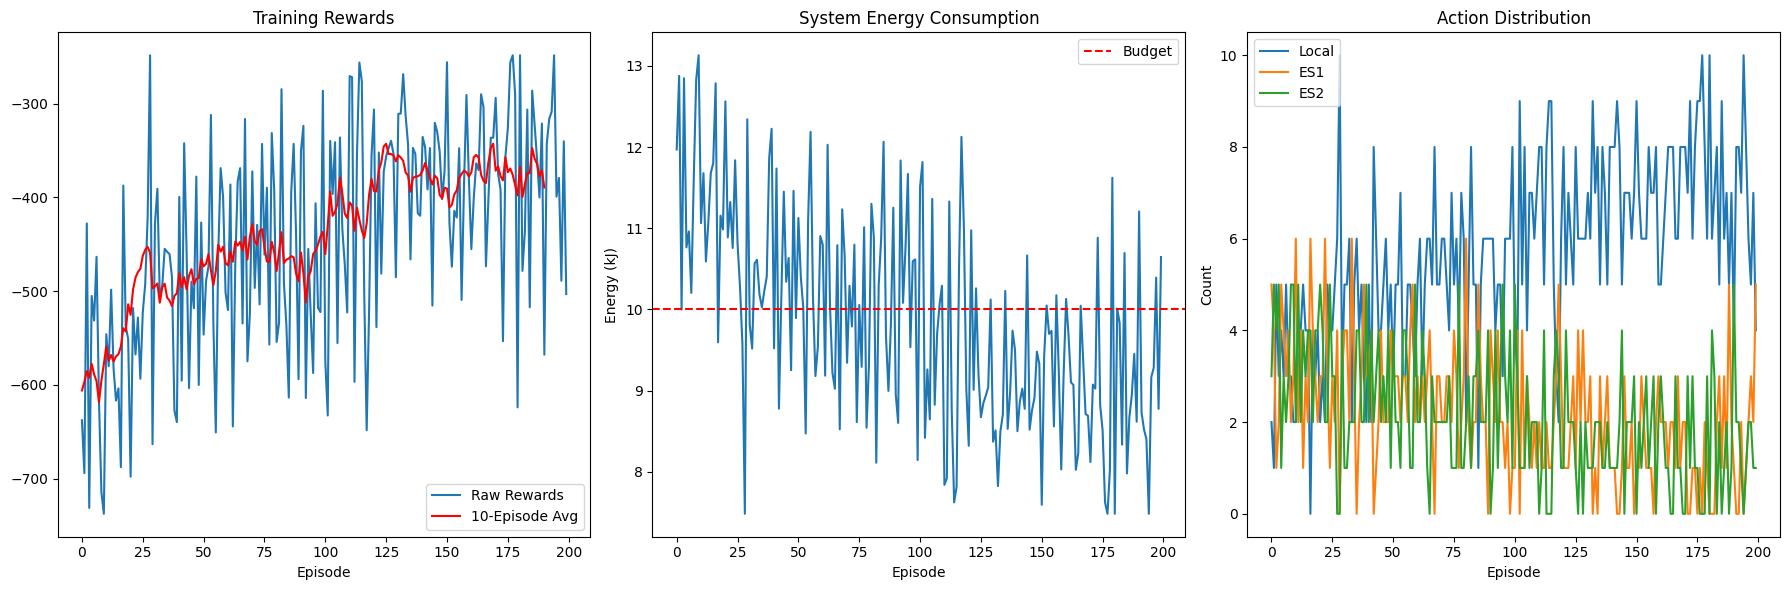

In [2]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random
import os



class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts
        self.start_time = None

    def start(self):
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        avg_cpu_usage = psutil.cpu_percent() / 100
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,
            "duration": duration
        }

class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0
        self.alpha = 0.6

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, episode, total_episodes, beta=0.4):
        # Dynamic alpha adjustment
        self.alpha = 0.4 + 0.3 * (episode/total_episodes)
        priorities = self.priorities[:len(self.buffer)] ** self.alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10):
        self.state_shape = None
        self.total_energy = 0
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        self.VOLTAGE_MD = 3.7
        self.VOLTAGE_ES = 12.0
        self.MAH_TO_J = 3.6
        self.operations_per_mb = 1e9
        
        # Reward parameters
        self.task_reward = 8.0
        self.energy_penalty_scale = 0.0015
        self.budget_penalty = 12.0
        self.efficiency_bonus = 2.0
        self.energy_budget = 10000
        
        # System parameters
        self.md_compute = np.random.uniform(1.5, 3.5, num_md)
        self.es_compute = np.random.uniform(25.0, 35.0, num_es)
        self.task_requirements = np.random.randint(150, 600, num_tasks)
        self.task_to_md = np.random.randint(0, num_md, num_tasks)
        self.md_energy_local = np.random.uniform(4.0, 10.0, num_md)
        self.md_energy_tx = np.random.uniform(0.6, 1.2, num_md)
        self.es_energy_process = np.random.uniform(35.0, 65.0, num_es)
        
        # Battery history for trend analysis
        self.md_battery_history = deque(maxlen=3)
        self.es_battery_history = deque(maxlen=3)
        
        self.reset()

    def reset(self):
        # Battery initialization
        self.initial_md_battery = np.random.randint(3500, 5501, self.num_md)
        self.initial_es_battery = np.random.randint(12000, 25001, self.num_es)
        
        self.md_battery = self.initial_md_battery * self.MAH_TO_J * self.VOLTAGE_MD
        self.es_battery = self.initial_es_battery * self.MAH_TO_J * self.VOLTAGE_ES
        
        # Energy budget constraints
        self.energy_budget = 10000  # kJ
        self.energy_used = 0
        self.total_energy = 0
        
        # Task tracking
        self.current_task = 0
        self.completed_tasks = 0
        self.violations = 0
        self.local_task_count = 0
        self.edge_task_count = 0
        
        # Initialize battery history with full array copies
        self.md_battery_history.clear()
        self.es_battery_history.clear()
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())
        
        return self._get_state()

    def _get_state(self):
        # Handle terminal state first
        if self.current_task >= self.num_tasks:
            if self.state_shape:
                return np.zeros(self.state_shape)
            # Fallback state size calculation if shape not initialized
            state_size = 7 + self.num_es * 5 + 2  # MD features + ES features + system
            return np.zeros(state_size)

        # Verify valid task index
        if self.current_task >= len(self.task_to_md):
            raise ValueError(f"Invalid task index {self.current_task}")
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        
        max_md_energy = 5000 * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = 20000 * self.MAH_TO_J * self.VOLTAGE_ES
        md_trend = np.mean([batts[md_idx] for batts in self.md_battery_history]) \
                   if self.md_battery_history else 0
        es_trend = np.mean([batts.mean() for batts in self.es_battery_history]) \
                   if self.es_battery_history else 0
        
        # Battery trends
        
        
        state = [
            # Mobile device features
            self.md_battery[md_idx] / max_md_energy,
            (self.md_battery[md_idx] - self.initial_md_battery[md_idx]) / max_md_energy,
            self.md_compute[md_idx] / 3.5,
            task_size / 600,
            self.md_energy_local[md_idx] / 10.0,
            self.md_energy_tx[md_idx] / 1.2,
            md_trend / max_md_energy,
        ]

        # Edge server features
        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / max_es_energy,
                (self.es_battery[es_idx] - self.initial_es_battery[es_idx]) / max_es_energy,
                self.es_compute[es_idx] / 35.0,
                self.es_energy_process[es_idx] / 65.0,
                es_trend / max_es_energy
            ])

        # System-wide features
        state.extend([
            self.current_task / self.num_tasks,
            self.energy_used / self.energy_budget
        ])
        
        if not self.state_shape:
            self.state_shape = np.array(state).shape
            
        return np.array(state, dtype=np.float32)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return self._get_state(), 0, True, {}
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        energy_used = 0
        reward = 0
        file_info = {"file_size_MB": task_size}
        
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())

        try:
            if action == 0:  # Local processing
                self.local_task_count += 1
                energy_needed = self.md_energy_local[md_idx] * (task_size * 1e9) / (self.md_compute[md_idx] * 1e9)
                
                if self.md_battery[md_idx] >= energy_needed:
                    self.md_battery[md_idx] -= energy_needed
                    energy_used = energy_needed
                    self.completed_tasks += 1
                    file_info["processed_at"] = f"MD{md_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError("Insufficient MD energy")

            else:  # Offload processing
                self.edge_task_count += 1
                es_idx = min(action - 1, self.num_es - 1)
                tx_energy = self.md_energy_tx[md_idx] * task_size * 2.5
                process_energy = (self.es_energy_process[es_idx] * 
                                 (task_size * 1e9) / (self.es_compute[es_idx] * 1e9))
                
                if self.md_battery[md_idx] >= tx_energy and self.es_battery[es_idx] >= process_energy:
                    self.md_battery[md_idx] -= tx_energy
                    self.es_battery[es_idx] -= process_energy
                    energy_used = tx_energy + process_energy
                    self.completed_tasks += 1
                    file_info["processed_at"] = f"ES{es_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError("Insufficient offload energy")

            # Calculate rewards
            energy_penalty = (energy_used ** 1.5) * self.energy_penalty_scale
            reward = self.task_reward - energy_penalty
            
            if energy_used < 500:
                reward += self.efficiency_bonus

        except RuntimeError:
            reward = -self.task_reward

        # Energy budget constraints
        self.total_energy += energy_used
        if self.total_energy > self.energy_budget:
            reward -= self.budget_penalty

        # Update battery history
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())

        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()
        
        file_info["energy_used_J"] = energy_used
        return next_state, reward, done, {"file_info": file_info}
    
        

class DQNAgent:
    def __init__(self, state_size, action_size, total_episodes=100):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(100000)
        self.batch_size = 256
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005
        self.tau = 0.12
        self.beta = 0.4
        self.network_layers = [256, 128]
        self.total_episodes = total_episodes
        
        # Normalization layer
        self.normalizer = tf.keras.layers.Normalization(axis=-1)
        
        self.model = self._build_network()
        self.target_model = self._build_network()
        self.update_target_network()

    def _build_network(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = self.normalizer(inputs)
        for units in self.network_layers:
            x = tf.keras.layers.Dense(units, activation='swish')(x)
            x = tf.keras.layers.LayerNormalization()(x)
            x = tf.keras.layers.Dropout(0.2)(x)
        
        # Dueling architecture
        value = tf.keras.layers.Dense(1)(x)
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        mean_advantage = tf.keras.layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        outputs = tf.keras.layers.Add()([value, tf.keras.layers.Subtract()([advantage, mean_advantage])])
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=self.learning_rate,
                    decay_steps=10000,
                    decay_rate=0.95
                ),
                clipnorm=1.0
            ),
            loss=tf.keras.losses.Huber()
        )
        return model

    def update_target_network(self):
        self.target_model.set_weights(
            [self.tau * w + (1 - self.tau) * tw 
             for w, tw in zip(self.model.get_weights(), self.target_model.get_weights())]
        )

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        return np.argmax(self.model.predict(state.reshape(1, -1), verbose=0))

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self, episode):
        if len(self.memory.buffer) < self.batch_size:
            return
            
        samples, indices, weights = self.memory.sample(
            self.batch_size, episode, self.total_episodes, self.beta)
        states, actions, rewards, next_states, dones = zip(*samples)
        
        states = np.array(states)
        next_states = np.array(next_states)
        
        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []

        for i in range(len(samples)):
            target = rewards[i] + (1 - dones[i]) * self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target

        self.model.fit(states, current_q, sample_weight=weights, 
                      batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        self.update_target_network()
        
def train_agent(episodes=200):
    tracker = EnergyTracker()
    env = MECEnvironment()
    state_size = len(env.reset())
    agent = DQNAgent(state_size, 1 + env.num_es, episodes)

    # Adapt normalizer with initial experiences
    states = []
    print("Adapting normalizer...")
    state = env.reset()
    for _ in range(1000):
        action = np.random.randint(agent.action_size)
        next_state, _, done, _ = env.step(action)
        states.append(state)
        state = next_state if not done else env.reset()
    agent.normalizer.adapt(np.array(states))

    rewards = []
    completion_rates = []
    energy_consumptions = []
    action_distributions = []
    episode_details = []
    epsilons = []
    betas = []

    best_avg = float('-inf')
    early_stop_counter = 0

    for episode in range(episodes):
        tracker.start()
        state = env.reset()
        
        # Capture initial state
        initial_md_battery = env.md_battery.copy()
        initial_es_battery = env.es_battery.copy()
        
        total_reward = 0
        done = False
        episode_actions = [0] * (env.num_es + 1)
        file_details = []

        # Epsilon management
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        epsilons.append(agent.epsilon)

        while not done:
            action = agent.act(state)
            episode_actions[action] += 1
            next_state, reward, done, info = env.step(action)
            
            # Collect file processing details
            file_details.append(info.get("file_info", {}))
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Update network
            if len(agent.memory.buffer) > agent.batch_size:
                agent.replay(episode)

        # Capture final state
        final_md_battery = env.md_battery.copy()
        final_es_battery = env.es_battery.copy()
        energy = tracker.stop()

        # Track metrics
        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks / env.num_tasks)
        energy_consumptions.append(env.total_energy / 1000)  # Convert to kJ
        action_distributions.append(episode_actions)
        betas.append(agent.beta)

        # Store episode details
        episode_info = {
            "episode": episode + 1,
            "initial_md_battery": initial_md_battery,
            "initial_es_battery": initial_es_battery,
            "final_md_battery": final_md_battery,
            "final_es_battery": final_es_battery,
            "file_details": file_details,
            "total_energy_consumed": env.total_energy
        }
        episode_details.append(episode_info)

        # Early stopping check
        if episode >= 150:
            recent_avg = np.mean(rewards[-10:])
            if recent_avg > best_avg:
                best_avg = recent_avg
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= 100:
                print(f"Early stopping at episode {episode+1}")
                break

        # Detailed episode logging
        print(f"\nEpisode {episode+1}/{episodes}")
        print(f"  Reward: {total_reward:.1f}")
        print(f"  Completed Tasks: {env.completed_tasks}/{env.num_tasks}")
        print(f"  Total Energy: {env.total_energy/1000:.1f}kJ (Budget: {env.energy_budget/1000:.1f}kJ)")
        print(f"  Local/Edge Tasks: {env.local_task_count}/{env.edge_task_count}")
        print(f"  Action Distribution: {episode_actions}")
        print(f"  Exploration Parameters: ε={agent.epsilon:.3f}, β={agent.beta:.3f}")
        print(f"  System Energy Usage: {energy['cpu_j']/1000:.1f}kJ")
        print("  Battery Status:")
        print(f"    Initial Mobile: {np.mean(initial_md_battery)/1000:.1f}kJ")
        print(f"    Final Mobile: {np.mean(final_md_battery)/1000:.1f}kJ")
        print(f"    Initial Edge: {np.mean(initial_es_battery)/1000:.1f}kJ")
        print(f"    Final Edge: {np.mean(final_es_battery)/1000:.1f}kJ")
        print("  File Processing Details:")
        for idx, detail in enumerate(file_details):
            print(f"    Task {idx+1}: {detail.get('file_size_MB', 'N/A')}MB "
                  f"processed at {detail.get('processed_at', 'N/A')} "
                  f"using {detail.get('energy_used_J', 0):.1f}J")

    # Performance visualization
    plt.figure(figsize=(18, 6))
    
    # Reward progression
    plt.subplot(1, 3, 1)
    plt.plot(rewards, label='Raw Rewards')
    plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), 'r-', label='10-Episode Avg')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.legend()

    # Energy consumption
    plt.subplot(1, 3, 2)
    plt.plot(energy_consumptions)
    plt.title('System Energy Consumption')
    plt.xlabel('Episode')
    plt.ylabel('Energy (kJ)')
    plt.axhline(y=env.energy_budget/1000, color='r', linestyle='--', label='Budget')
    plt.legend()

    # Action distribution
    plt.subplot(1, 3, 3)
    actions_matrix = np.array(action_distributions).T
    labels = ['Local'] + [f'ES{i+1}' for i in range(env.num_es)]
    for i, label in enumerate(labels):
        plt.plot(actions_matrix[i], label=label)
    plt.title('Action Distribution')
    plt.xlabel('Episode')
    plt.ylabel('Count')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'rewards': rewards,
        'energy': energy_consumptions,
        'completion': completion_rates,
        'actions': action_distributions,
        'details': episode_details
    }

if __name__ == "__main__":
    tf.keras.backend.clear_session()
    results = train_agent()

New model with changed rewards under stress



Total minimal energy required: 12680.40 J

Energy Allocation:
Total Budget: 19.0 kJ
MD Allocation: 9.5 kJ
ES Allocation: 9.5 kJ
Per MD Battery: [237 237 237] mAh
Per ES Battery: [110 110] mAh

Energy Allocation:
Total Budget: 19.0 kJ
MD Allocation: 9.5 kJ
ES Allocation: 9.5 kJ
Per MD Battery: [237 237 237] mAh
Per ES Battery: [110 110] mAh
Adapting normalizer...

Energy Allocation:
Total Budget: 19.0 kJ
MD Allocation: 9.5 kJ
ES Allocation: 9.5 kJ
Per MD Battery: [237 237 237] mAh
Per ES Battery: [110 110] mAh

Energy Allocation:
Total Budget: 19.0 kJ
MD Allocation: 9.5 kJ
ES Allocation: 9.5 kJ
Per MD Battery: [237 237 237] mAh
Per ES Battery: [110 110] mAh

Energy Allocation:
Total Budget: 19.0 kJ
MD Allocation: 9.5 kJ
ES Allocation: 9.5 kJ
Per MD Battery: [237 237 237] mAh
Per ES Battery: [110 110] mAh

Energy Allocation:
Total Budget: 19.0 kJ
MD Allocation: 9.5 kJ
ES Allocation: 9.5 kJ
Per MD Battery: [237 237 237] mAh
Per ES Battery: [110 110] mAh

Energy Allocation:
Total Budget: 1

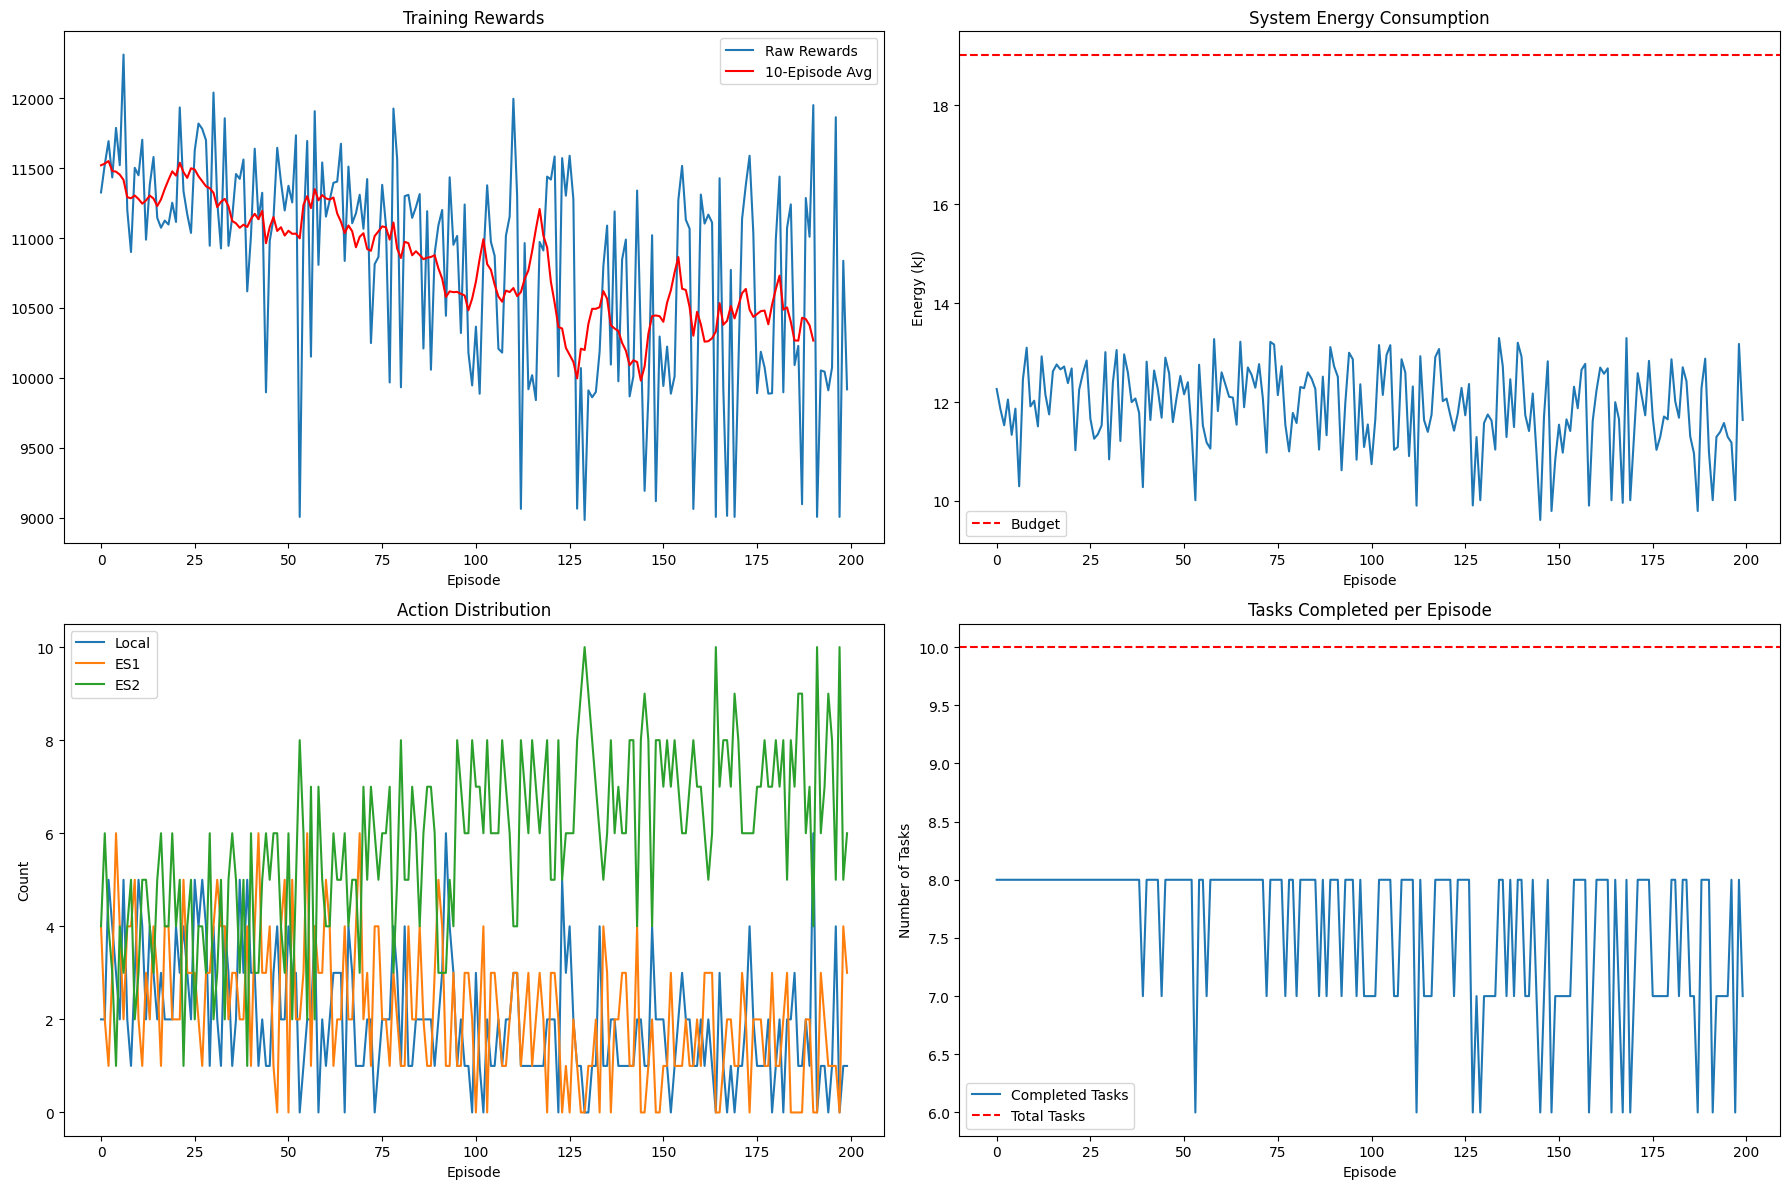

In [10]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random
import os



class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts
        self.start_time = None

    def start(self):
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        avg_cpu_usage = psutil.cpu_percent() / 100
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,
            "duration": duration
        }

class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0
        self.alpha = 0.6

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, episode, total_episodes, beta=0.4):
        # Dynamic alpha adjustment
        self.alpha = 0.4 + 0.3 * (episode/total_episodes)
        priorities = self.priorities[:len(self.buffer)] ** self.alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10):
        self.state_shape = None
        self.total_energy = 0
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        self.VOLTAGE_MD = 3.7
        self.VOLTAGE_ES = 12.0
        self.MAH_TO_J = 3.6
        self.operations_per_mb = 1e9
        self.local_task_count = 0
        self.edge_task_count = 0
        
        # Reward parameters
        self.base_task_reward = 30.0
        self.energy_efficiency_multiplier = 0.5
        self.budget_utilization_factor = 0.8
        self.battery_conservation_bonus = 1.5
        self.consecutive_success_factor = 2.0
        
        # New dynamic parameters
        self.optimal_energy_threshold = 0.85  # 90% of minimal theoretical energy
        self.energy_use_history = deque(maxlen=5)
        self.consecutive_successes = 0
        
        # System parameters
        self.md_compute = np.random.uniform(1.5, 3.5, num_md)
        self.es_compute = np.random.uniform(25.0, 35.0, num_es)
        self.task_requirements = np.random.randint(150, 600, num_tasks)
        self.task_to_md = np.random.randint(0, num_md, num_tasks)
        self.md_energy_local = np.random.uniform(4.0, 10.0, num_md)
        self.md_energy_tx = np.random.uniform(0.6, 1.2, num_md)
        self.es_energy_process = np.random.uniform(35.0, 65.0, num_es)
        
        self.optimal_actions = []
        self.md_energy_required = np.zeros(num_md)
        self.es_energy_required = np.zeros(num_es)
        self.minimal_total_energy = 0

        # Calculate optimal energy requirements
        for task in range(num_tasks):
            md_idx = self.task_to_md[task]
            task_size = self.task_requirements[task]
            
            # Local processing energy
            local_energy = ((self.md_energy_local[md_idx] * 
                           (task_size * 1e9)) / (self.md_compute[md_idx]*1e9))
            
            # Find minimal offload energy
            min_offload = float('inf')
            best_es = -1
            for es_idx in range(num_es):
                tx_energy = self.md_energy_tx[md_idx] * task_size * 2.5
                process_energy = ((self.es_energy_process[es_idx] * 
                                 task_size*1e9) / (self.es_compute[es_idx]*1e9))
                total_offload = tx_energy + process_energy
                if total_offload < min_offload:
                    min_offload = total_offload
                    best_es = es_idx

            # Track optimal energy usage
            if local_energy <= min_offload:
                self.optimal_actions.append(0)
                self.md_energy_required[md_idx] += local_energy
            else:
                self.optimal_actions.append(best_es + 1)
                self.md_energy_required[md_idx] += tx_energy
                self.es_energy_required[best_es] += process_energy

        # Calculate minimal total energy
        self.minimal_total_energy = (self.md_energy_required.sum() +
                                    self.es_energy_required.sum())
        print(f"Total minimal energy required: {self.minimal_total_energy:.2f} J")
        
        # Battery history for trend analysis
        self.md_battery_history = deque(maxlen=3)
        self.es_battery_history = deque(maxlen=3)
        
        self.reset()

    def reset(self):
        # Calculate total energy budget (150% of minimal required)
        total_budget = self.minimal_total_energy *1.5
        self.energy_budget = total_budget
        
        # Allocate 50% to MDs, 50% to ESs
        md_total = total_budget * 0.5
        es_total = total_budget * 0.5
        
        # Calculate per-device energy in Joules
        md_energy_per = md_total / self.num_md
        es_energy_per = es_total / self.num_es
        
        # Convert to battery capacities (mAh)
        self.initial_md_battery = np.full(
            self.num_md,
            int(md_energy_per / (self.VOLTAGE_MD * self.MAH_TO_J)),
            dtype=int
        )
        self.initial_es_battery = np.full(
            self.num_es,
            int(es_energy_per / (self.VOLTAGE_ES * self.MAH_TO_J)),
            dtype=int
        )
        
        # Convert to Joules for energy tracking
        self.md_battery = self.initial_md_battery * self.MAH_TO_J * self.VOLTAGE_MD
        self.es_battery = self.initial_es_battery * self.MAH_TO_J * self.VOLTAGE_ES
        
        # Energy verification
        total_allocated = self.md_battery.sum() + self.es_battery.sum()
        print(f"\nEnergy Allocation:")
        print(f"Total Budget: {total_budget/1000:.1f} kJ")
        print(f"MD Allocation: {self.md_battery.sum()/1000:.1f} kJ")
        print(f"ES Allocation: {self.es_battery.sum()/1000:.1f} kJ")
        print(f"Per MD Battery: {self.initial_md_battery} mAh")
        print(f"Per ES Battery: {self.initial_es_battery} mAh")
        
        # Initialize task tracking
        self.current_task = 0
        self.completed_tasks = 0
        self.violations = 0
        self.total_energy = 0
        self.local_task_count = 0
        self.edge_task_count = 0
                
        # Initialize battery history with full array copies
        self.md_battery_history.clear()
        self.es_battery_history.clear()
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())
        
        return self._get_state()

    def _get_state(self):
        # Handle terminal state first
        if self.current_task >= self.num_tasks:
            if self.state_shape:
                return np.zeros(self.state_shape)
            # Fallback state size calculation if shape not initialized
            state_size = 7 + self.num_es * 5 + 2  # MD features + ES features + system
            return np.zeros(state_size)

        # Verify valid task index
        if self.current_task >= len(self.task_to_md):
            raise ValueError(f"Invalid task index {self.current_task}")
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        
        max_md_energy = self.initial_md_battery[md_idx] * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = self.initial_es_battery * self.MAH_TO_J * self.VOLTAGE_ES  # For all ES
        md_trend = np.mean([batts[md_idx] for batts in self.md_battery_history]) \
                   if self.md_battery_history else 0
        es_trend = np.mean([batts.mean() for batts in self.es_battery_history]) \
                   if self.es_battery_history else 0
        
        # Battery trends
        
        
        state = [
            # Mobile device features
            self.md_battery[md_idx] / max_md_energy,
            (self.md_battery[md_idx] - self.initial_md_battery[md_idx]) / max_md_energy,
            self.md_compute[md_idx] / 3.5,
            task_size / 600,
            self.md_energy_local[md_idx] / 10.0,
            self.md_energy_tx[md_idx] / 1.2,
            md_trend / max_md_energy,
        ]

        # Edge server features
        # Edge server features
        for es_idx in range(self.num_es):
            es_max_energy = self.initial_es_battery[es_idx] * self.MAH_TO_J * self.VOLTAGE_ES
            state.extend([
                self.es_battery[es_idx] / es_max_energy,
                (self.es_battery[es_idx] - self.initial_es_battery[es_idx]) / es_max_energy,
                self.es_compute[es_idx] / 35.0,
                self.es_energy_process[es_idx] / 65.0,
                es_trend / es_max_energy
            ])

        # System-wide features
        state.extend([
            self.current_task / self.num_tasks,
            self.total_energy / self.energy_budget
        ])
        
        if not self.state_shape:
            self.state_shape = np.array(state).shape
            
        return np.array(state, dtype=np.float32)

    def step(self, action):
      if self.current_task >= self.num_tasks:
          return self._get_state(), 0, True, {}
      
      md_idx = self.task_to_md[self.current_task]
      task_size = self.task_requirements[self.current_task]
      energy_used = 0
      reward = 0
      file_info = {"file_size_MB": task_size}
      task_completed = False

      # Convert initial battery capacities to Joules (pre-calculated)
      initial_md_joules = self.initial_md_battery * self.MAH_TO_J * self.VOLTAGE_MD
      initial_es_joules = self.initial_es_battery * self.MAH_TO_J * self.VOLTAGE_ES

      try:
          # Get optimal energy for current task
          task_idx = self.current_task
          if self.optimal_actions[task_idx] == 0:
              optimal_energy = self.md_energy_required[self.task_to_md[task_idx]]
          else:
              es_idx = self.optimal_actions[task_idx] - 1
              optimal_energy = (self.md_energy_tx[self.task_to_md[task_idx]] * 
                              task_size * 2.5) + self.es_energy_required[es_idx]

          # Process task based on action
          if action == 0:  # Local processing
              energy_needed = self.md_energy_local[md_idx] * (task_size * 1e9) / (self.md_compute[md_idx] * 1e9)
              
              if self.md_battery[md_idx] >= energy_needed:
                  self.md_battery[md_idx] -= energy_needed
                  energy_used = energy_needed
                  self.completed_tasks += 1
                  self.local_task_count += 1
                  task_completed = True
                  file_info["processed_at"] = f"MD{md_idx}"
              else:
                  energy_used = 0  # Failed processing
                  self.violations += 1

          else:  # Offload processing
              es_idx = min(action - 1, self.num_es - 1)
              tx_energy = self.md_energy_tx[md_idx] * task_size * 2.5
              process_energy = (self.es_energy_process[es_idx] * 
                              (task_size * 1e9) / (self.es_compute[es_idx] * 1e9))
              
              if self.md_battery[md_idx] >= tx_energy and self.es_battery[es_idx] >= process_energy:
                  self.md_battery[md_idx] -= tx_energy
                  self.es_battery[es_idx] -= process_energy
                  energy_used = tx_energy + process_energy
                  self.completed_tasks += 1
                  self.edge_task_count += 1
                  task_completed = True
                  file_info["processed_at"] = f"ES{es_idx}"
              else:
                  energy_used = 0  # Failed processing
                  self.violations += 1

          # Update total energy consumption
          self.total_energy += energy_used

          # Calculate rewards only for successful tasks
          if task_completed:
              # Energy efficiency component
              energy_ratio = energy_used / optimal_energy
              energy_efficiency = 15 * (1 / (1 + np.exp(3 * (energy_ratio - 1.1))))
              
              # Battery conservation components
              md_conservation = np.mean(self.md_battery) / np.mean(initial_md_joules)
              es_conservation = np.mean(self.es_battery) / np.mean(initial_es_joules)
              battery_conservation = (md_conservation + es_conservation) / 2
              
              # Core reward components
              reward = (
                  self.base_task_reward * (1 + self.consecutive_successes/10) +
                  energy_efficiency +
                  5 * battery_conservation +
                  4 * (optimal_energy / max(energy_used, 1e-6)) +
                  2 * np.log(1 + self.consecutive_successes)
              )

              # Bonus for beating optimal energy
              if energy_used < optimal_energy:
                  reward += self.energy_efficiency_multiplier * (optimal_energy - energy_used)
              
              # Budget utilization bonus
              if self.total_energy < self.energy_budget * 0.8:
                  reward += self.budget_utilization_factor * (self.energy_budget - self.total_energy)/self.energy_budget
              
              self.consecutive_successes += 1
          else:
              # Penalty for failed task
              reward = -self.base_task_reward * (1 + (self.total_energy / self.energy_budget))
              self.consecutive_successes = 0

          # Universal penalties (apply regardless of task success)
          # Budget violation penalty
          budget_violation = max(0, self.total_energy - self.energy_budget)
          reward -= self.budget_utilization_factor * (budget_violation ** 1.0)
          
          # Battery conservation penalty
          min_battery_ratio = np.min(self.md_battery / initial_md_joules)
          reward -= 8 * np.exp(-5 * min_battery_ratio)

      except Exception as e:
          print(f"Error processing task: {str(e)}")
          reward = -self.base_task_reward
          self.consecutive_successes = 0

      # Update battery history
      self.md_battery_history.append(self.md_battery.copy())
      self.es_battery_history.append(self.es_battery.copy())

      self.current_task += 1
      done = self.current_task >= self.num_tasks
      next_state = self._get_state()
      
      file_info["energy_used_J"] = energy_used
      return next_state, reward, done, {"file_info": file_info}
    
        

class DQNAgent:
    def __init__(self, state_size, action_size, total_episodes=100):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(100000)
        self.batch_size = 256
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005
        self.tau = 0.12
        self.beta = 0.4
        self.network_layers = [256, 128]
        self.total_episodes = total_episodes
        
        # Normalization layer
        self.normalizer = tf.keras.layers.Normalization(axis=-1)
        
        self.model = self._build_network()
        self.target_model = self._build_network()
        self.update_target_network()

    def _build_network(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = self.normalizer(inputs)
        for units in self.network_layers:
            x = tf.keras.layers.Dense(units, activation='swish')(x)
            x = tf.keras.layers.LayerNormalization()(x)
            x = tf.keras.layers.Dropout(0.2)(x)
        
        # Dueling architecture
        value = tf.keras.layers.Dense(1)(x)
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        mean_advantage = tf.keras.layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        outputs = tf.keras.layers.Add()([value, tf.keras.layers.Subtract()([advantage, mean_advantage])])
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=self.learning_rate,
                    decay_steps=10000,
                    decay_rate=0.95
                ),
                clipnorm=1.0
            ),
            loss=tf.keras.losses.Huber()
        )
        return model

    def update_target_network(self):
        self.target_model.set_weights(
            [self.tau * w + (1 - self.tau) * tw 
             for w, tw in zip(self.model.get_weights(), self.target_model.get_weights())]
        )

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        return np.argmax(self.model.predict(state.reshape(1, -1), verbose=0))

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self, episode):
        if len(self.memory.buffer) < self.batch_size:
            return
            
        samples, indices, weights = self.memory.sample(
            self.batch_size, episode, self.total_episodes, self.beta)
        states, actions, rewards, next_states, dones = zip(*samples)
        
        states = np.array(states)
        next_states = np.array(next_states)
        
        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []

        for i in range(len(samples)):
            target = rewards[i] + (1 - dones[i]) * self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target

        self.model.fit(states, current_q, sample_weight=weights, 
                      batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        self.update_target_network()
        
def train_agent(episodes=200):
    tracker = EnergyTracker()
    env = MECEnvironment()
    state_size = len(env.reset())
    agent = DQNAgent(state_size, 1 + env.num_es, episodes)

    # Adapt normalizer with initial experiences
    states = []
    print("Adapting normalizer...")
    state = env.reset()
    for _ in range(1000):
        action = np.random.randint(agent.action_size)
        next_state, _, done, _ = env.step(action)
        states.append(state)
        state = next_state if not done else env.reset()
    agent.normalizer.adapt(np.array(states))

    rewards = []
    completion_rates = []
    energy_consumptions = []
    action_distributions = []
    episode_details = []
    epsilons = []
    betas = []
    tasks_completed = [] 

    best_avg = float('-inf')
    early_stop_counter = 0

    for episode in range(episodes):
        tracker.start()
        state = env.reset()
        
        # Capture initial state
        initial_md_battery = env.md_battery.copy()
        initial_es_battery = env.es_battery.copy()
        
        total_reward = 0
        done = False
        episode_actions = [0] * (env.num_es + 1)
        file_details = []

        # Epsilon management
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        epsilons.append(agent.epsilon)

        while not done:
            action = agent.act(state)
            episode_actions[action] += 1
            next_state, reward, done, info = env.step(action)
            
            # Collect file processing details
            file_details.append(info.get("file_info", {}))
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Update network
            if len(agent.memory.buffer) > agent.batch_size:
                agent.replay(episode)

        # Capture final state
        final_md_battery = env.md_battery.copy()
        final_es_battery = env.es_battery.copy()
        energy = tracker.stop()

        # Track metrics
        rewards.append(total_reward)
        completed_tasks = env.completed_tasks
        tasks_completed.append(completed_tasks)
        completion_rates.append(completed_tasks / env.num_tasks)
        energy_consumptions.append(env.total_energy / 1000)  # Convert to kJ
        action_distributions.append(episode_actions)
        betas.append(agent.beta)

        # Store episode details
        episode_info = {
            "episode": episode + 1,
            "initial_md_battery": initial_md_battery,
            "initial_es_battery": initial_es_battery,
            "final_md_battery": final_md_battery,
            "final_es_battery": final_es_battery,
            "file_details": file_details,
            "total_energy_consumed": env.total_energy
        }
        episode_details.append(episode_info)

        # Early stopping check
        if episode >= 150:
            recent_avg = np.mean(rewards[-10:])
            if recent_avg > best_avg:
                best_avg = recent_avg
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= 300:
                print(f"Early stopping at episode {episode+1}")
                break

        # Detailed episode logging
        print(f"\nEpisode {episode+1}/{episodes}")
        print(f"  Reward: {total_reward:.1f}")
        print(f"  Completed Tasks: {env.completed_tasks}/{env.num_tasks}")
        print(f"  Total Energy: {env.total_energy/1000:.1f}kJ (Budget: {env.energy_budget/1000:.1f}kJ)")
        print(f"  Local/Edge Tasks: {env.local_task_count}/{env.edge_task_count}")
        print(f"  Action Distribution: {episode_actions}")
        print(f"  Exploration Parameters: ε={agent.epsilon:.3f}, β={agent.beta:.3f}")
        print(f"  System Energy Usage: {energy['cpu_j']/1000:.1f}kJ")
        print("  Battery Status:")
        print(f"    Initial Mobile: {np.mean(initial_md_battery)/1000:.1f}kJ")
        print(f"    Final Mobile: {np.mean(final_md_battery)/1000:.1f}kJ")
        print(f"    Initial Edge: {np.mean(initial_es_battery)/1000:.1f}kJ")
        print(f"    Final Edge: {np.mean(final_es_battery)/1000:.1f}kJ")
        print("  File Processing Details:")
        for idx, detail in enumerate(file_details):
            print(f"    Task {idx+1}: {detail.get('file_size_MB', 'N/A')}MB "
                  f"processed at {detail.get('processed_at', 'N/A')} "
                  f"using {detail.get('energy_used_J', 0):.1f}J")

    # Performance visualization
    # Modify the visualization section to 2x2 grid and add tasks completed plot:
    # Performance visualization
    plt.figure(figsize=(18, 12))  # Increased figure size
    
    # Reward progression
    plt.subplot(2, 2, 1)
    plt.plot(rewards, label='Raw Rewards')
    plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), 'r-', label='10-Episode Avg')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.legend()

    # Energy consumption
    plt.subplot(2, 2, 2)
    plt.plot(energy_consumptions)
    plt.title('System Energy Consumption')
    plt.xlabel('Episode')
    plt.ylabel('Energy (kJ)')
    plt.axhline(y=env.energy_budget/1000, color='r', linestyle='--', label='Budget')
    plt.legend()

    # Action distribution
    plt.subplot(2, 2, 3)
    actions_matrix = np.array(action_distributions).T
    labels = ['Local'] + [f'ES{i+1}' for i in range(env.num_es)]
    for i, label in enumerate(labels):
        plt.plot(actions_matrix[i], label=label)
    plt.title('Action Distribution')
    plt.xlabel('Episode')
    plt.ylabel('Count')
    plt.legend()

    # New tasks completed plot
    plt.subplot(2, 2, 4)
    plt.plot(tasks_completed, label='Completed Tasks')
    plt.axhline(y=env.num_tasks, color='r', linestyle='--', label='Total Tasks')
    plt.title('Tasks Completed per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Number of Tasks')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'rewards': rewards,
        'energy': energy_consumptions,
        'completion': completion_rates,
        'actions': action_distributions,
        'details': episode_details
    }

if __name__ == "__main__":
    tf.keras.backend.clear_session()
    results = train_agent()

New Model under stress


Total minimal energy required: 10065.68 J

Energy Allocation:
Total Budget: 15.1 kJ
MD Allocation: 7.5 kJ
ES Allocation: 7.5 kJ
Per MD Battery: [188 188 188] mAh
Per ES Battery: [87 87] mAh

Energy Allocation:
Total Budget: 15.1 kJ
MD Allocation: 7.5 kJ
ES Allocation: 7.5 kJ
Per MD Battery: [188 188 188] mAh
Per ES Battery: [87 87] mAh
Adapting normalizer...

Energy Allocation:
Total Budget: 15.1 kJ
MD Allocation: 7.5 kJ
ES Allocation: 7.5 kJ
Per MD Battery: [188 188 188] mAh
Per ES Battery: [87 87] mAh

Energy Allocation:
Total Budget: 15.1 kJ
MD Allocation: 7.5 kJ
ES Allocation: 7.5 kJ
Per MD Battery: [188 188 188] mAh
Per ES Battery: [87 87] mAh

Energy Allocation:
Total Budget: 15.1 kJ
MD Allocation: 7.5 kJ
ES Allocation: 7.5 kJ
Per MD Battery: [188 188 188] mAh
Per ES Battery: [87 87] mAh

Energy Allocation:
Total Budget: 15.1 kJ
MD Allocation: 7.5 kJ
ES Allocation: 7.5 kJ
Per MD Battery: [188 188 188] mAh
Per ES Battery: [87 87] mAh

Energy Allocation:
Total Budget: 15.1 kJ
MD Al

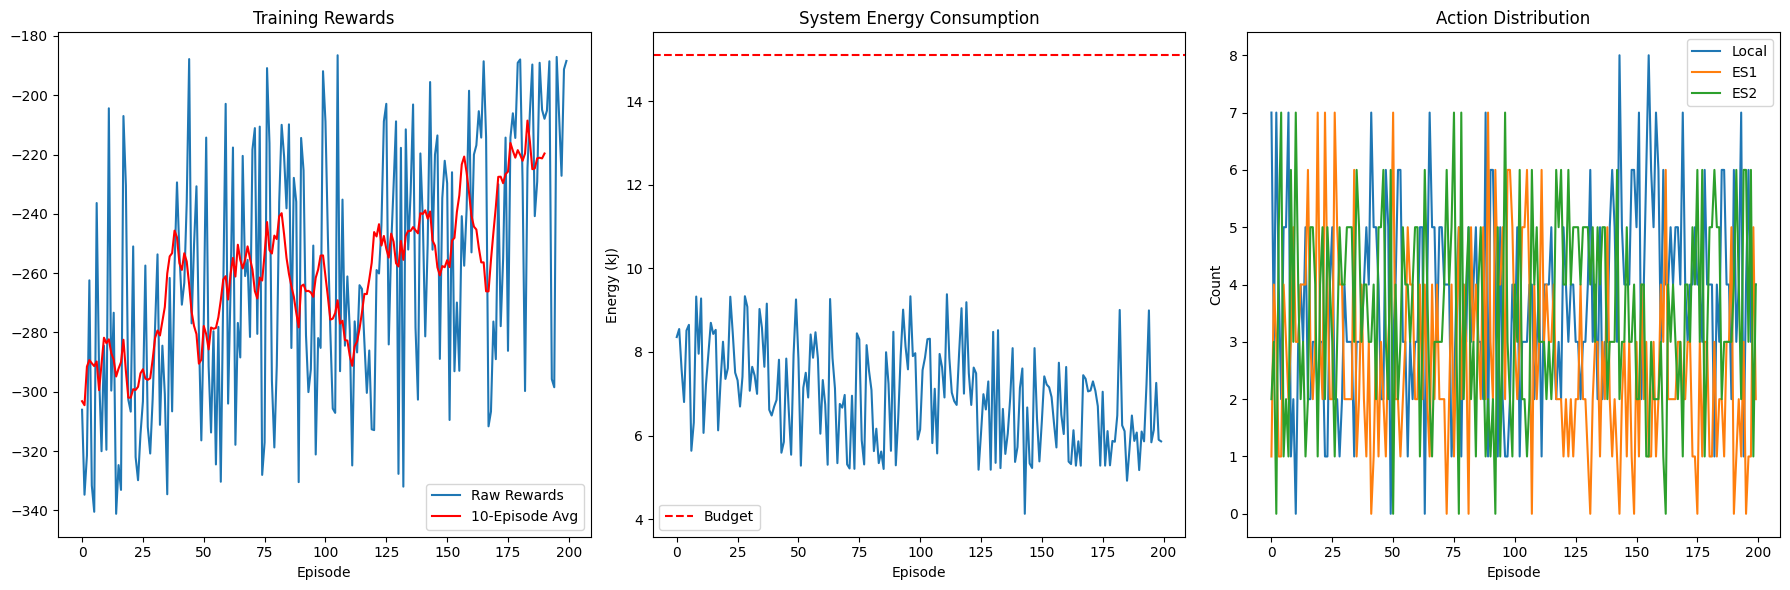

In [4]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random
import os



class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts
        self.start_time = None

    def start(self):
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        avg_cpu_usage = psutil.cpu_percent() / 100
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,
            "duration": duration
        }

class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0
        self.alpha = 0.6

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, episode, total_episodes, beta=0.4):
        # Dynamic alpha adjustment
        self.alpha = 0.4 + 0.3 * (episode/total_episodes)
        priorities = self.priorities[:len(self.buffer)] ** self.alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10):
        self.state_shape = None
        self.total_energy = 0
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        self.VOLTAGE_MD = 3.7
        self.VOLTAGE_ES = 12.0
        self.MAH_TO_J = 3.6
        self.operations_per_mb = 1e9
        self.local_task_count = 0
        self.edge_task_count = 0
        
        # Reward parameters
        self.task_reward = 20.0
        self.energy_penalty_scale = 0.0015
        self.budget_penalty = 12.0
        self.efficiency_bonus = 2.0
        self.energy_budget = 10000
        
        # System parameters
        self.md_compute = np.random.uniform(1.5, 3.5, num_md)
        self.es_compute = np.random.uniform(25.0, 35.0, num_es)
        self.task_requirements = np.random.randint(150, 600, num_tasks)
        self.task_to_md = np.random.randint(0, num_md, num_tasks)
        self.md_energy_local = np.random.uniform(4.0, 10.0, num_md)
        self.md_energy_tx = np.random.uniform(0.6, 1.2, num_md)
        self.es_energy_process = np.random.uniform(35.0, 65.0, num_es)
        
        self.optimal_actions = []
        self.md_energy_required = np.zeros(num_md)
        self.es_energy_required = np.zeros(num_es)
        self.minimal_total_energy = 0

        # Calculate optimal energy requirements
        for task in range(num_tasks):
            md_idx = self.task_to_md[task]
            task_size = self.task_requirements[task]
            
            # Local processing energy
            local_energy = ((self.md_energy_local[md_idx] * 
                           (task_size * 1e9)) / (self.md_compute[md_idx]*1e9))
            
            # Find minimal offload energy
            min_offload = float('inf')
            best_es = -1
            for es_idx in range(num_es):
                tx_energy = self.md_energy_tx[md_idx] * task_size * 2.5
                process_energy = ((self.es_energy_process[es_idx] * 
                                 task_size*1e9) / (self.es_compute[es_idx]*1e9))
                total_offload = tx_energy + process_energy
                if total_offload < min_offload:
                    min_offload = total_offload
                    best_es = es_idx

            # Track optimal energy usage
            if local_energy <= min_offload:
                self.optimal_actions.append(0)
                self.md_energy_required[md_idx] += local_energy
            else:
                self.optimal_actions.append(best_es + 1)
                self.md_energy_required[md_idx] += tx_energy
                self.es_energy_required[best_es] += process_energy

        # Calculate minimal total energy
        self.minimal_total_energy = (self.md_energy_required.sum() +
                                    self.es_energy_required.sum())
        print(f"Total minimal energy required: {self.minimal_total_energy:.2f} J")
        
        # Battery history for trend analysis
        self.md_battery_history = deque(maxlen=3)
        self.es_battery_history = deque(maxlen=3)
        
        self.reset()

    def reset(self):
        # Calculate total energy budget (105% of minimal required)
        total_budget = self.minimal_total_energy *1.5
        self.energy_budget = total_budget
        
        # Allocate 50% to MDs, 50% to ESs
        md_total = total_budget * 0.5
        es_total = total_budget * 0.5
        
        # Calculate per-device energy in Joules
        md_energy_per = md_total / self.num_md
        es_energy_per = es_total / self.num_es
        
        # Convert to battery capacities (mAh)
        self.initial_md_battery = np.full(
            self.num_md,
            int(md_energy_per / (self.VOLTAGE_MD * self.MAH_TO_J)),
            dtype=int
        )
        self.initial_es_battery = np.full(
            self.num_es,
            int(es_energy_per / (self.VOLTAGE_ES * self.MAH_TO_J)),
            dtype=int
        )
        
        # Convert to Joules for energy tracking
        self.md_battery = self.initial_md_battery * self.MAH_TO_J * self.VOLTAGE_MD
        self.es_battery = self.initial_es_battery * self.MAH_TO_J * self.VOLTAGE_ES
        
        # Energy verification
        total_allocated = self.md_battery.sum() + self.es_battery.sum()
        print(f"\nEnergy Allocation:")
        print(f"Total Budget: {total_budget/1000:.1f} kJ")
        print(f"MD Allocation: {self.md_battery.sum()/1000:.1f} kJ")
        print(f"ES Allocation: {self.es_battery.sum()/1000:.1f} kJ")
        print(f"Per MD Battery: {self.initial_md_battery} mAh")
        print(f"Per ES Battery: {self.initial_es_battery} mAh")
        
        # Initialize task tracking
        self.current_task = 0
        self.completed_tasks = 0
        self.violations = 0
        self.total_energy = 0
        self.local_task_count = 0
        self.edge_task_count = 0
                
        # Initialize battery history with full array copies
        self.md_battery_history.clear()
        self.es_battery_history.clear()
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())
        
        return self._get_state()

    def _get_state(self):
        # Handle terminal state first
        if self.current_task >= self.num_tasks:
            if self.state_shape:
                return np.zeros(self.state_shape)
            # Fallback state size calculation if shape not initialized
            state_size = 7 + self.num_es * 5 + 2  # MD features + ES features + system
            return np.zeros(state_size)

        # Verify valid task index
        if self.current_task >= len(self.task_to_md):
            raise ValueError(f"Invalid task index {self.current_task}")
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        
        max_md_energy = self.initial_md_battery[md_idx] * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = self.initial_es_battery * self.MAH_TO_J * self.VOLTAGE_ES  # For all ES
        md_trend = np.mean([batts[md_idx] for batts in self.md_battery_history]) \
                   if self.md_battery_history else 0
        es_trend = np.mean([batts.mean() for batts in self.es_battery_history]) \
                   if self.es_battery_history else 0
        
        # Battery trends
        
        
        state = [
            # Mobile device features
            self.md_battery[md_idx] / max_md_energy,
            (self.md_battery[md_idx] - self.initial_md_battery[md_idx]) / max_md_energy,
            self.md_compute[md_idx] / 3.5,
            task_size / 600,
            self.md_energy_local[md_idx] / 10.0,
            self.md_energy_tx[md_idx] / 1.2,
            md_trend / max_md_energy,
        ]

        # Edge server features
        # Edge server features
        for es_idx in range(self.num_es):
            es_max_energy = self.initial_es_battery[es_idx] * self.MAH_TO_J * self.VOLTAGE_ES
            state.extend([
                self.es_battery[es_idx] / es_max_energy,
                (self.es_battery[es_idx] - self.initial_es_battery[es_idx]) / es_max_energy,
                self.es_compute[es_idx] / 35.0,
                self.es_energy_process[es_idx] / 65.0,
                es_trend / es_max_energy
            ])

        # System-wide features
        state.extend([
            self.current_task / self.num_tasks,
            self.total_energy / self.energy_budget
        ])
        
        if not self.state_shape:
            self.state_shape = np.array(state).shape
            
        return np.array(state, dtype=np.float32)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return self._get_state(), 0, True, {}
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        energy_used = 0
        reward = 0
        file_info = {"file_size_MB": task_size}
        
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())

        try:
            if action == 0:  # Local processing
                self.local_task_count += 1
                energy_needed = self.md_energy_local[md_idx] * (task_size * 1e9) / (self.md_compute[md_idx] * 1e9)
                
                if self.md_battery[md_idx] >= energy_needed:
                    self.md_battery[md_idx] -= energy_needed
                    energy_used = energy_needed
                    self.completed_tasks += 1
                    file_info["processed_at"] = f"MD{md_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError("Insufficient MD energy")

            else:  # Offload processing
                self.edge_task_count += 1
                es_idx = min(action - 1, self.num_es - 1)
                tx_energy = self.md_energy_tx[md_idx] * task_size * 2.5
                process_energy = (self.es_energy_process[es_idx] * 
                                 (task_size * 1e9) / (self.es_compute[es_idx] * 1e9))
                
                if self.md_battery[md_idx] >= tx_energy and self.es_battery[es_idx] >= process_energy:
                    self.md_battery[md_idx] -= tx_energy
                    self.es_battery[es_idx] -= process_energy
                    energy_used = tx_energy + process_energy
                    self.completed_tasks += 1
                    file_info["processed_at"] = f"ES{es_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError("Insufficient offload energy")

            # Calculate rewards
            energy_penalty = (energy_used ** 1.5) * self.energy_penalty_scale
            reward = self.task_reward - energy_penalty
            
            if energy_used < 500:
                reward += self.efficiency_bonus

        except RuntimeError:
            reward = -self.task_reward

        # Energy budget constraints
        self.total_energy += energy_used
        if self.total_energy > self.energy_budget:
            reward -= self.budget_penalty

        # Update battery history
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())

        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()
        
        file_info["energy_used_J"] = energy_used
        return next_state, reward, done, {"file_info": file_info}
    
        

class DQNAgent:
    def __init__(self, state_size, action_size, total_episodes=100):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(100000)
        self.batch_size = 256
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005
        self.tau = 0.12
        self.beta = 0.4
        self.network_layers = [256, 128]
        self.total_episodes = total_episodes
        
        # Normalization layer
        self.normalizer = tf.keras.layers.Normalization(axis=-1)
        
        self.model = self._build_network()
        self.target_model = self._build_network()
        self.update_target_network()

    def _build_network(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = self.normalizer(inputs)
        for units in self.network_layers:
            x = tf.keras.layers.Dense(units, activation='swish')(x)
            x = tf.keras.layers.LayerNormalization()(x)
            x = tf.keras.layers.Dropout(0.2)(x)
        
        # Dueling architecture
        value = tf.keras.layers.Dense(1)(x)
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        mean_advantage = tf.keras.layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        outputs = tf.keras.layers.Add()([value, tf.keras.layers.Subtract()([advantage, mean_advantage])])
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=self.learning_rate,
                    decay_steps=10000,
                    decay_rate=0.95
                ),
                clipnorm=1.0
            ),
            loss=tf.keras.losses.Huber()
        )
        return model

    def update_target_network(self):
        self.target_model.set_weights(
            [self.tau * w + (1 - self.tau) * tw 
             for w, tw in zip(self.model.get_weights(), self.target_model.get_weights())]
        )

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        return np.argmax(self.model.predict(state.reshape(1, -1), verbose=0))

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self, episode):
        if len(self.memory.buffer) < self.batch_size:
            return
            
        samples, indices, weights = self.memory.sample(
            self.batch_size, episode, self.total_episodes, self.beta)
        states, actions, rewards, next_states, dones = zip(*samples)
        
        states = np.array(states)
        next_states = np.array(next_states)
        
        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []

        for i in range(len(samples)):
            target = rewards[i] + (1 - dones[i]) * self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target

        self.model.fit(states, current_q, sample_weight=weights, 
                      batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        self.update_target_network()
        
def train_agent(episodes=200):
    tracker = EnergyTracker()
    env = MECEnvironment()
    state_size = len(env.reset())
    agent = DQNAgent(state_size, 1 + env.num_es, episodes)

    # Adapt normalizer with initial experiences
    states = []
    print("Adapting normalizer...")
    state = env.reset()
    for _ in range(1000):
        action = np.random.randint(agent.action_size)
        next_state, _, done, _ = env.step(action)
        states.append(state)
        state = next_state if not done else env.reset()
    agent.normalizer.adapt(np.array(states))

    rewards = []
    completion_rates = []
    energy_consumptions = []
    action_distributions = []
    episode_details = []
    epsilons = []
    betas = []

    best_avg = float('-inf')
    early_stop_counter = 0

    for episode in range(episodes):
        tracker.start()
        state = env.reset()
        
        # Capture initial state
        initial_md_battery = env.md_battery.copy()
        initial_es_battery = env.es_battery.copy()
        
        total_reward = 0
        done = False
        episode_actions = [0] * (env.num_es + 1)
        file_details = []

        # Epsilon management
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        epsilons.append(agent.epsilon)

        while not done:
            action = agent.act(state)
            episode_actions[action] += 1
            next_state, reward, done, info = env.step(action)
            
            # Collect file processing details
            file_details.append(info.get("file_info", {}))
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Update network
            if len(agent.memory.buffer) > agent.batch_size:
                agent.replay(episode)

        # Capture final state
        final_md_battery = env.md_battery.copy()
        final_es_battery = env.es_battery.copy()
        energy = tracker.stop()

        # Track metrics
        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks / env.num_tasks)
        energy_consumptions.append(env.total_energy / 1000)  # Convert to kJ
        action_distributions.append(episode_actions)
        betas.append(agent.beta)

        # Store episode details
        episode_info = {
            "episode": episode + 1,
            "initial_md_battery": initial_md_battery,
            "initial_es_battery": initial_es_battery,
            "final_md_battery": final_md_battery,
            "final_es_battery": final_es_battery,
            "file_details": file_details,
            "total_energy_consumed": env.total_energy
        }
        episode_details.append(episode_info)

        # Early stopping check
        if episode >= 150:
            recent_avg = np.mean(rewards[-10:])
            if recent_avg > best_avg:
                best_avg = recent_avg
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= 100:
                print(f"Early stopping at episode {episode+1}")
                break

        # Detailed episode logging
        print(f"\nEpisode {episode+1}/{episodes}")
        print(f"  Reward: {total_reward:.1f}")
        print(f"  Completed Tasks: {env.completed_tasks}/{env.num_tasks}")
        print(f"  Total Energy: {env.total_energy/1000:.1f}kJ (Budget: {env.energy_budget/1000:.1f}kJ)")
        print(f"  Local/Edge Tasks: {env.local_task_count}/{env.edge_task_count}")
        print(f"  Action Distribution: {episode_actions}")
        print(f"  Exploration Parameters: ε={agent.epsilon:.3f}, β={agent.beta:.3f}")
        print(f"  System Energy Usage: {energy['cpu_j']/1000:.1f}kJ")
        print("  Battery Status:")
        print(f"    Initial Mobile: {np.mean(initial_md_battery)/1000:.1f}kJ")
        print(f"    Final Mobile: {np.mean(final_md_battery)/1000:.1f}kJ")
        print(f"    Initial Edge: {np.mean(initial_es_battery)/1000:.1f}kJ")
        print(f"    Final Edge: {np.mean(final_es_battery)/1000:.1f}kJ")
        print("  File Processing Details:")
        for idx, detail in enumerate(file_details):
            print(f"    Task {idx+1}: {detail.get('file_size_MB', 'N/A')}MB "
                  f"processed at {detail.get('processed_at', 'N/A')} "
                  f"using {detail.get('energy_used_J', 0):.1f}J")

    # Performance visualization
    plt.figure(figsize=(18, 6))
    
    # Reward progression
    plt.subplot(1, 3, 1)
    plt.plot(rewards, label='Raw Rewards')
    plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), 'r-', label='10-Episode Avg')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.legend()

    # Energy consumption
    plt.subplot(1, 3, 2)
    plt.plot(energy_consumptions)
    plt.title('System Energy Consumption')
    plt.xlabel('Episode')
    plt.ylabel('Energy (kJ)')
    plt.axhline(y=env.energy_budget/1000, color='r', linestyle='--', label='Budget')
    plt.legend()

    # Action distribution
    plt.subplot(1, 3, 3)
    actions_matrix = np.array(action_distributions).T
    labels = ['Local'] + [f'ES{i+1}' for i in range(env.num_es)]
    for i, label in enumerate(labels):
        plt.plot(actions_matrix[i], label=label)
    plt.title('Action Distribution')
    plt.xlabel('Episode')
    plt.ylabel('Count')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'rewards': rewards,
        'energy': energy_consumptions,
        'completion': completion_rates,
        'actions': action_distributions,
        'details': episode_details
    }

if __name__ == "__main__":
    tf.keras.backend.clear_session()
    results = train_agent()



=== Running CONSERVATIVE configuration ===
Adapting normalizer...

Episode 1/300
  Reward: -835.5
  Total Energy: 12.2kJ
  Action Distribution: [3, 2, 5]

Episode 2/300
  Reward: -829.2
  Total Energy: 12.1kJ
  Action Distribution: [4, 3, 3]

Episode 3/300
  Reward: -624.1
  Total Energy: 10.4kJ
  Action Distribution: [6, 2, 2]

Episode 4/300
  Reward: -757.5
  Total Energy: 11.6kJ
  Action Distribution: [4, 3, 3]

Episode 5/300
  Reward: -968.4
  Total Energy: 13.2kJ
  Action Distribution: [2, 6, 2]

Episode 6/300
  Reward: -845.0
  Total Energy: 12.3kJ
  Action Distribution: [3, 4, 3]

Episode 7/300
  Reward: -789.7
  Total Energy: 11.9kJ
  Action Distribution: [4, 4, 2]

Episode 8/300
  Reward: -676.3
  Total Energy: 11.0kJ
  Action Distribution: [5, 3, 2]

Episode 9/300
  Reward: -687.7
  Total Energy: 11.1kJ
  Action Distribution: [4, 3, 3]

Episode 10/300
  Reward: -708.8
  Total Energy: 11.0kJ
  Action Distribution: [6, 4, 0]

Episode 11/300
  Reward: -922.8
  Total Energy: 13

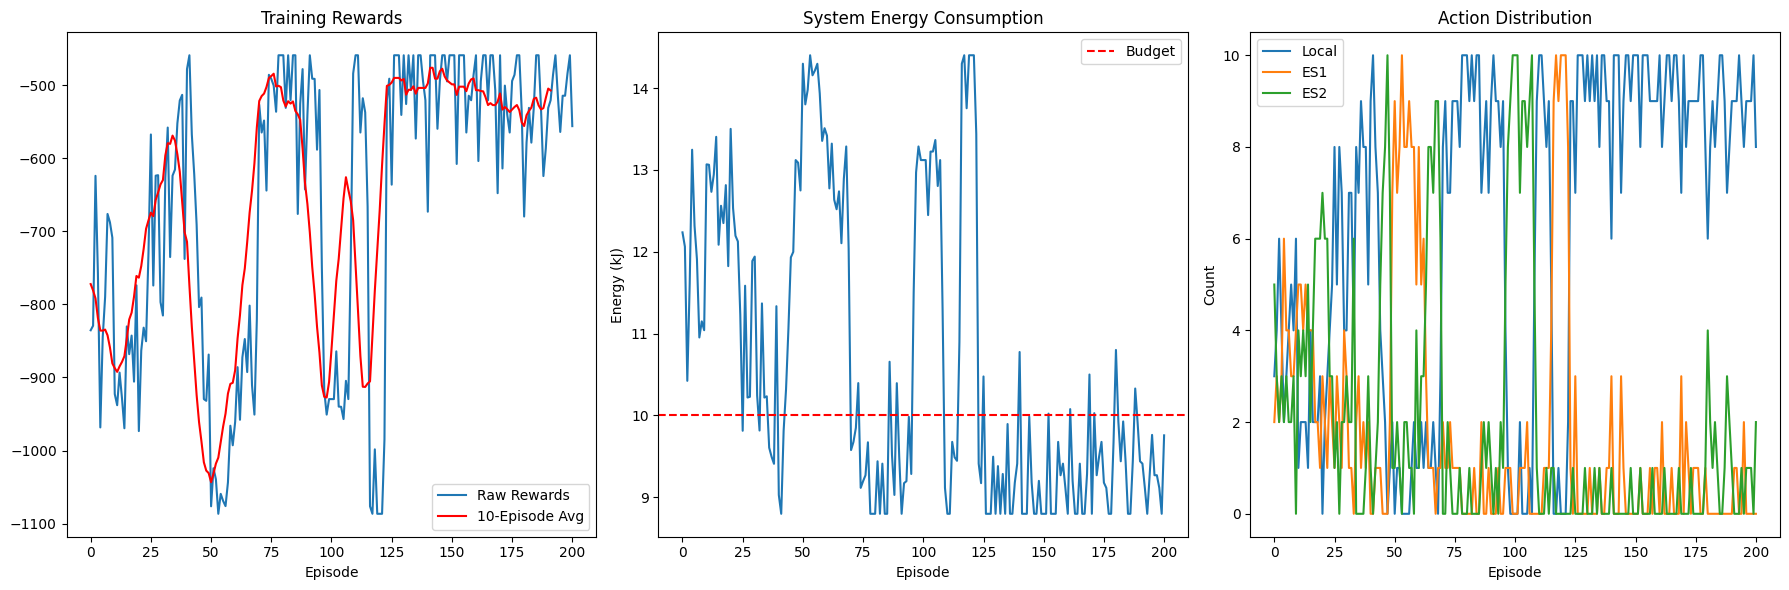


=== Running AGGRESSIVE configuration ===
Adapting normalizer...

Episode 1/300
  Reward: -655.2
  Total Energy: 13.1kJ
  Action Distribution: [6, 1, 3]

Episode 2/300
  Reward: -893.7
  Total Energy: 15.5kJ
  Action Distribution: [1, 3, 6]

Episode 3/300
  Reward: -986.6
  Total Energy: 16.5kJ
  Action Distribution: [1, 5, 4]

Episode 4/300
  Reward: -873.1
  Total Energy: 15.2kJ
  Action Distribution: [3, 5, 2]

Episode 5/300
  Reward: -841.9
  Total Energy: 15.2kJ
  Action Distribution: [5, 4, 1]

Episode 6/300
  Reward: -668.1
  Total Energy: 13.2kJ
  Action Distribution: [4, 1, 5]

Episode 7/300
  Reward: -736.1
  Total Energy: 13.9kJ
  Action Distribution: [5, 4, 1]

Episode 8/300
  Reward: -966.6
  Total Energy: 16.2kJ
  Action Distribution: [3, 4, 3]

Episode 9/300
  Reward: -663.2
  Total Energy: 13.2kJ
  Action Distribution: [5, 0, 5]

Episode 10/300
  Reward: -933.0
  Total Energy: 16.0kJ
  Action Distribution: [0, 4, 6]

Episode 11/300
  Reward: -797.9
  Total Energy: 14.6k

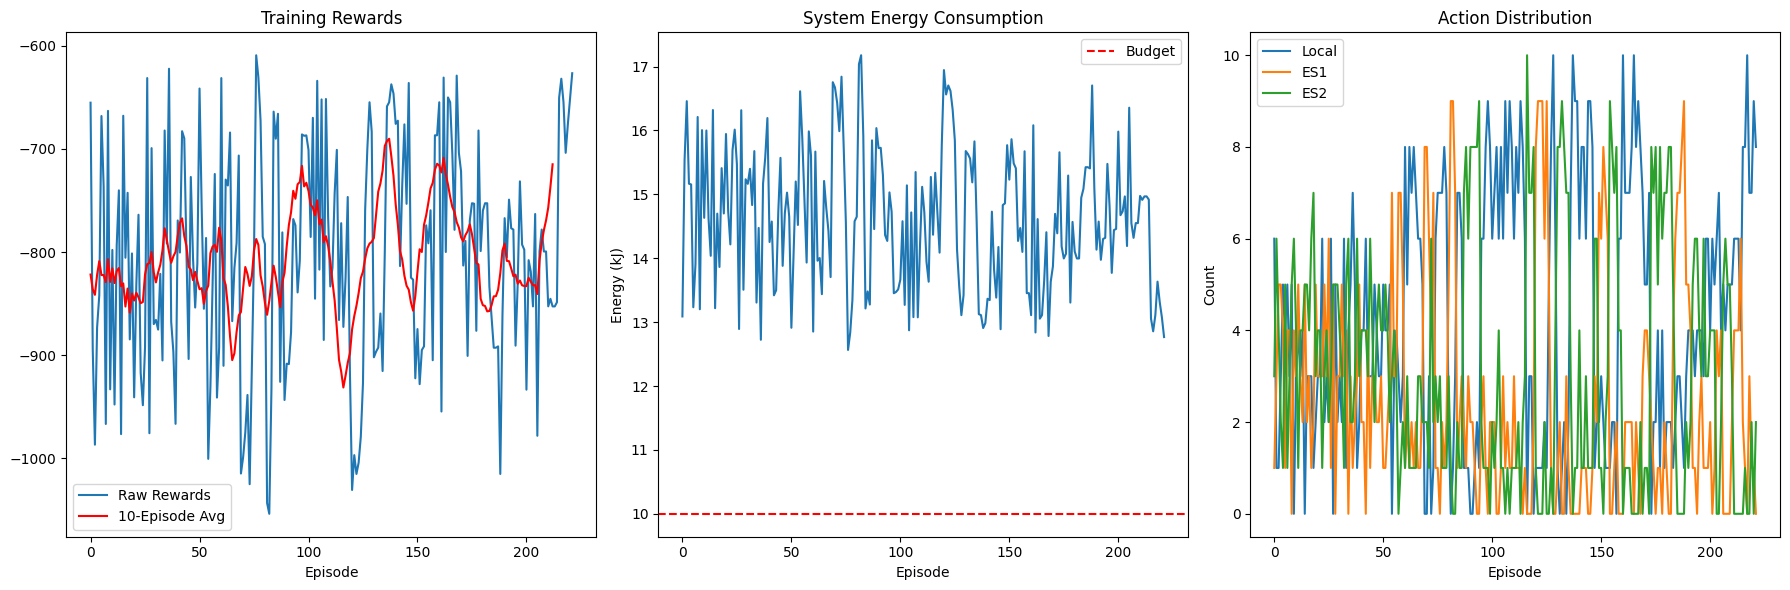


=== Running BALANCED configuration ===
Adapting normalizer...

Episode 1/300
  Reward: -646.4
  Total Energy: 12.4kJ
  Action Distribution: [3, 3, 4]

Episode 2/300
  Reward: -602.8
  Total Energy: 12.0kJ
  Action Distribution: [2, 4, 4]

Episode 3/300
  Reward: -636.7
  Total Energy: 12.3kJ
  Action Distribution: [2, 3, 5]

Episode 4/300
  Reward: -655.4
  Total Energy: 12.6kJ
  Action Distribution: [1, 5, 4]

Episode 5/300
  Reward: -520.4
  Total Energy: 11.2kJ
  Action Distribution: [3, 2, 5]

Episode 6/300
  Reward: -681.0
  Total Energy: 12.8kJ
  Action Distribution: [1, 4, 5]

Episode 7/300
  Reward: -691.8
  Total Energy: 13.0kJ
  Action Distribution: [3, 3, 4]

Episode 8/300
  Reward: -646.8
  Total Energy: 12.5kJ
  Action Distribution: [5, 3, 2]

Episode 9/300
  Reward: -637.0
  Total Energy: 12.2kJ
  Action Distribution: [5, 2, 3]

Episode 10/300
  Reward: -605.5
  Total Energy: 12.0kJ
  Action Distribution: [3, 5, 2]

Episode 11/300
  Reward: -607.4
  Total Energy: 12.0kJ


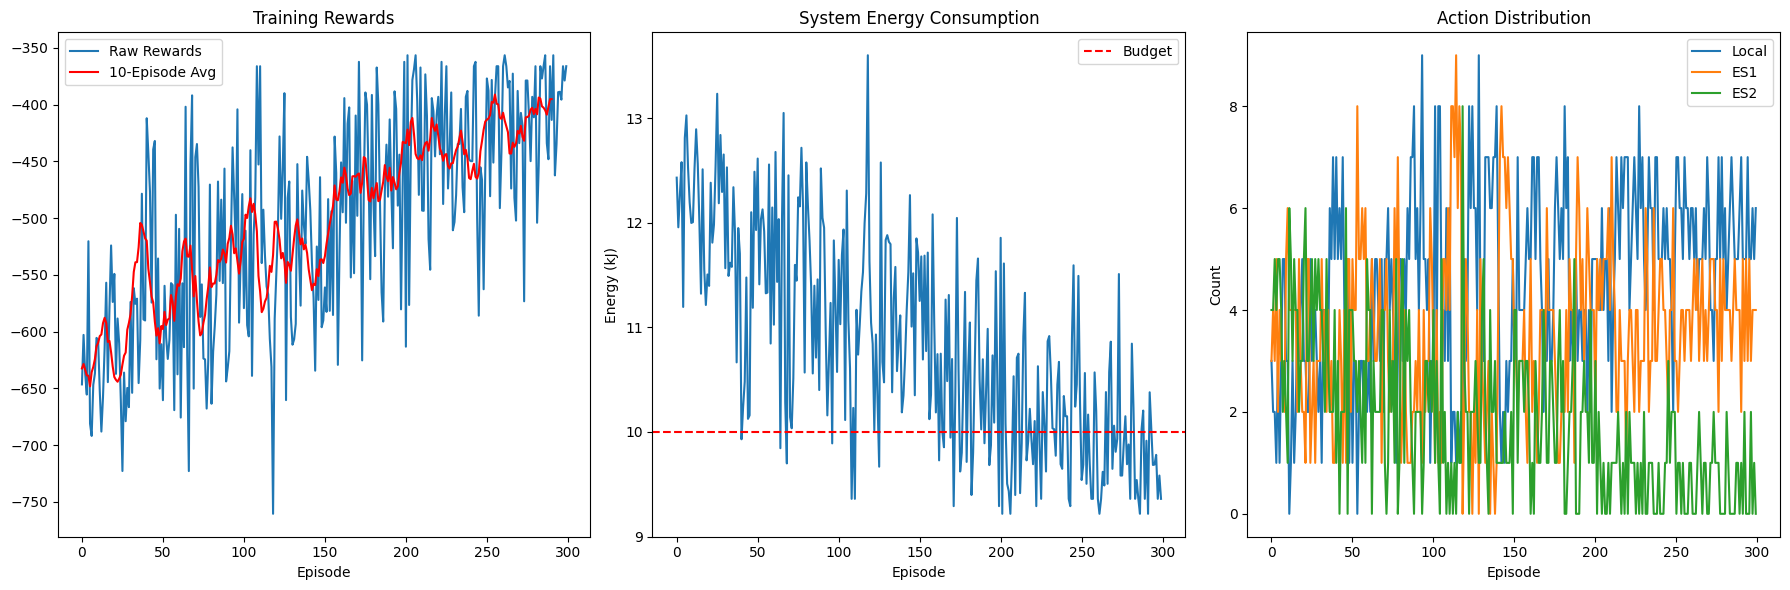


=== Running HP6 configuration ===
Adapting normalizer...

Episode 1/300
  Reward: -309.5
  Total Energy: 10.7kJ
  Action Distribution: [3, 2, 5]

Episode 2/300
  Reward: -486.6
  Total Energy: 13.1kJ
  Action Distribution: [4, 3, 3]

Episode 3/300
  Reward: -374.8
  Total Energy: 11.9kJ
  Action Distribution: [1, 5, 4]

Episode 4/300
  Reward: -588.0
  Total Energy: 14.0kJ
  Action Distribution: [4, 5, 1]

Episode 5/300
  Reward: -492.9
  Total Energy: 12.9kJ
  Action Distribution: [5, 1, 4]

Episode 6/300
  Reward: -409.8
  Total Energy: 12.4kJ
  Action Distribution: [4, 5, 1]

Episode 7/300
  Reward: -473.6
  Total Energy: 12.6kJ
  Action Distribution: [3, 2, 5]

Episode 8/300
  Reward: -328.1
  Total Energy: 11.1kJ
  Action Distribution: [1, 3, 6]

Episode 9/300
  Reward: -374.5
  Total Energy: 11.8kJ
  Action Distribution: [3, 0, 7]

Episode 10/300
  Reward: -471.7
  Total Energy: 12.7kJ
  Action Distribution: [2, 2, 6]

Episode 11/300
  Reward: -563.9
  Total Energy: 13.5kJ
  Act

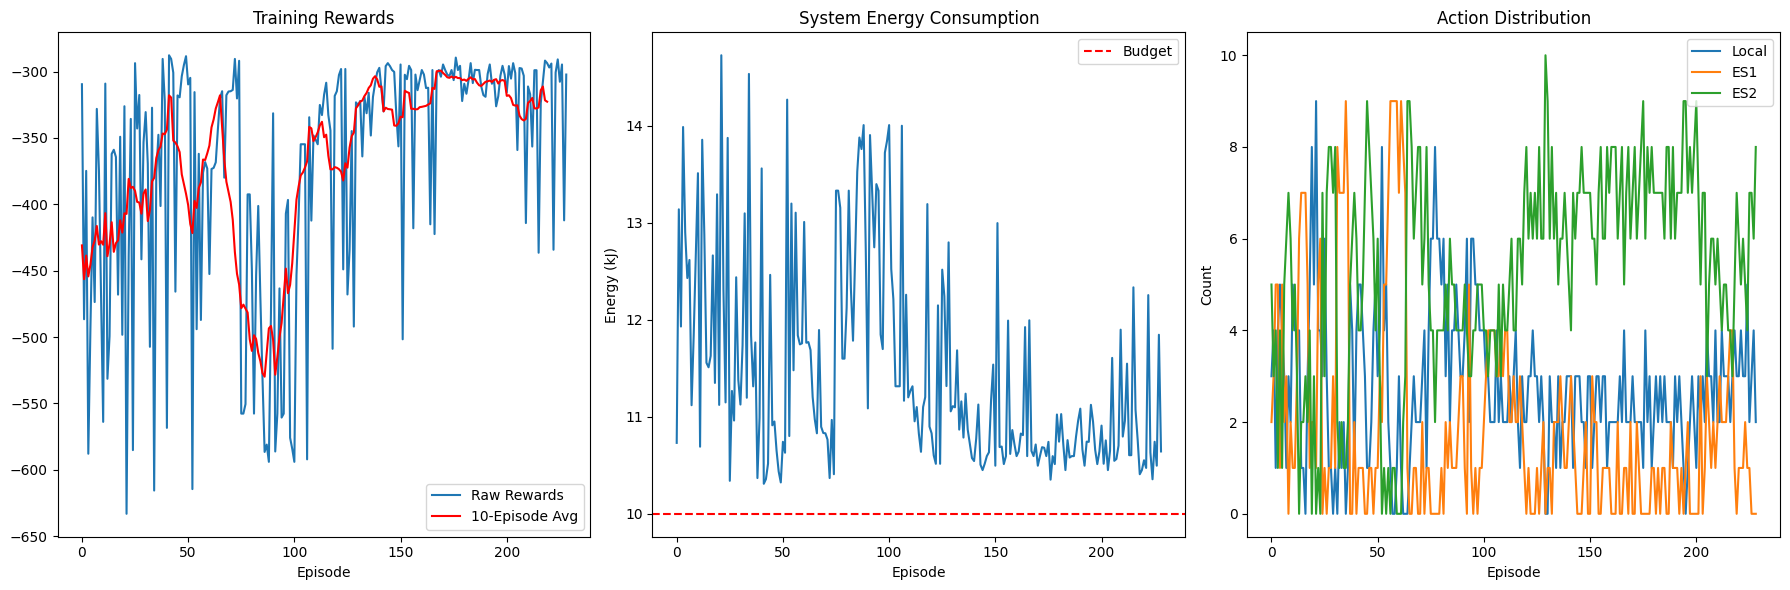


=== Running HP5 configuration ===
Adapting normalizer...

Episode 1/300
  Reward: -439.8
  Total Energy: 10.1kJ
  Action Distribution: [4, 3, 3]

Episode 2/300
  Reward: -447.4
  Total Energy: 10.2kJ
  Action Distribution: [2, 4, 4]

Episode 3/300
  Reward: -432.4
  Total Energy: 10.0kJ
  Action Distribution: [3, 3, 4]

Episode 4/300
  Reward: -398.0
  Total Energy: 9.7kJ
  Action Distribution: [1, 1, 8]

Episode 5/300
  Reward: -446.0
  Total Energy: 10.2kJ
  Action Distribution: [1, 3, 6]

Episode 6/300
  Reward: -483.4
  Total Energy: 10.6kJ
  Action Distribution: [3, 5, 2]

Episode 7/300
  Reward: -430.0
  Total Energy: 10.0kJ
  Action Distribution: [4, 3, 3]

Episode 8/300
  Reward: -430.6
  Total Energy: 10.1kJ
  Action Distribution: [0, 4, 6]

Episode 9/300
  Reward: -436.2
  Total Energy: 10.0kJ
  Action Distribution: [4, 3, 3]

Episode 10/300
  Reward: -467.5
  Total Energy: 10.4kJ
  Action Distribution: [5, 4, 1]

Episode 11/300
  Reward: -471.2
  Total Energy: 10.5kJ
  Acti

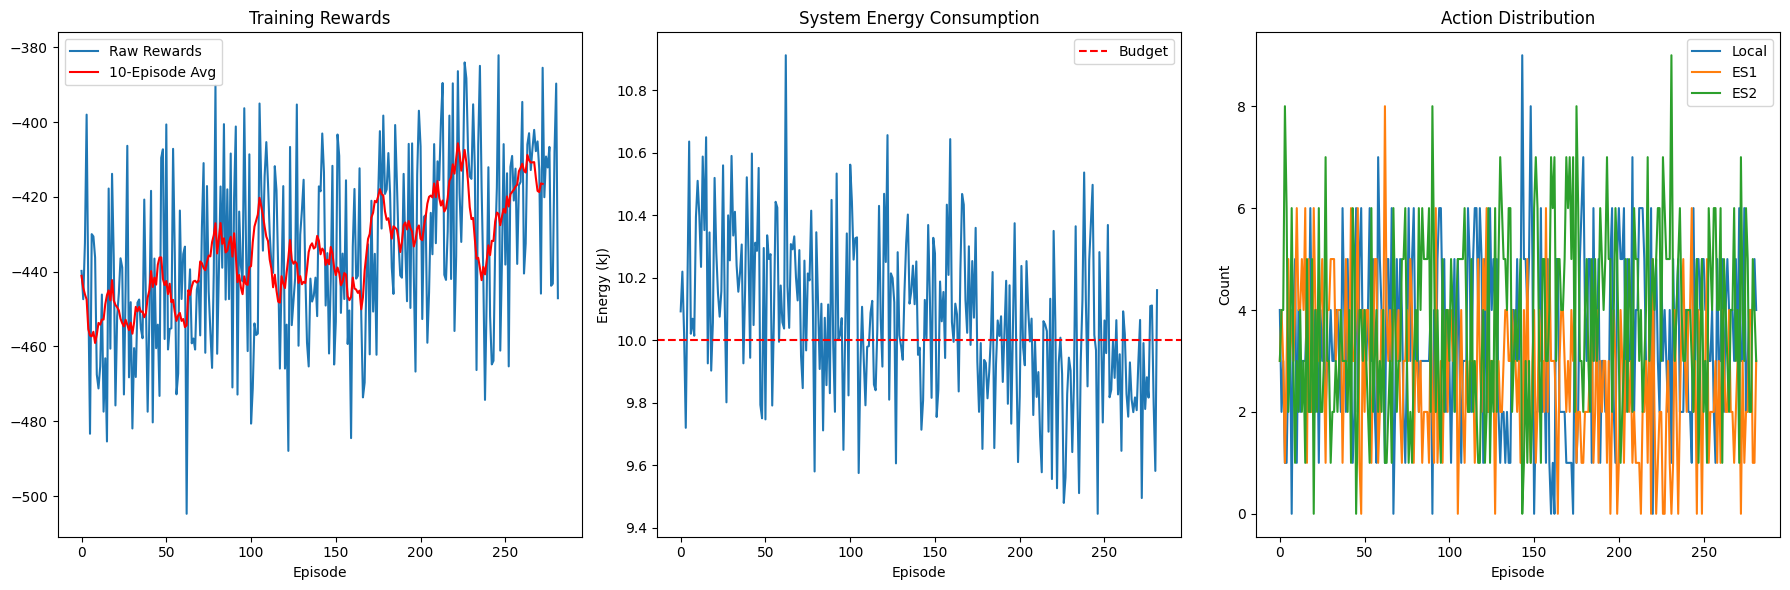


=== Running HP4 configuration ===
Adapting normalizer...

Episode 1/300
  Reward: -1134.9
  Total Energy: 17.7kJ
  Action Distribution: [4, 3, 3]

Episode 2/300
  Reward: -1094.8
  Total Energy: 17.4kJ
  Action Distribution: [4, 3, 3]

Episode 3/300
  Reward: -1332.3
  Total Energy: 19.9kJ
  Action Distribution: [3, 1, 6]

Episode 4/300
  Reward: -1013.8
  Total Energy: 16.9kJ
  Action Distribution: [1, 6, 3]

Episode 5/300
  Reward: -1206.8
  Total Energy: 18.7kJ
  Action Distribution: [3, 3, 4]

Episode 6/300
  Reward: -1254.8
  Total Energy: 19.1kJ
  Action Distribution: [3, 2, 5]

Episode 7/300
  Reward: -1147.0
  Total Energy: 18.1kJ
  Action Distribution: [2, 5, 3]

Episode 8/300
  Reward: -1073.1
  Total Energy: 17.4kJ
  Action Distribution: [3, 5, 2]

Episode 9/300
  Reward: -1108.4
  Total Energy: 17.6kJ
  Action Distribution: [1, 6, 3]

Episode 10/300
  Reward: -1038.9
  Total Energy: 16.9kJ
  Action Distribution: [3, 7, 0]

Episode 11/300
  Reward: -1065.1
  Total Energy: 1

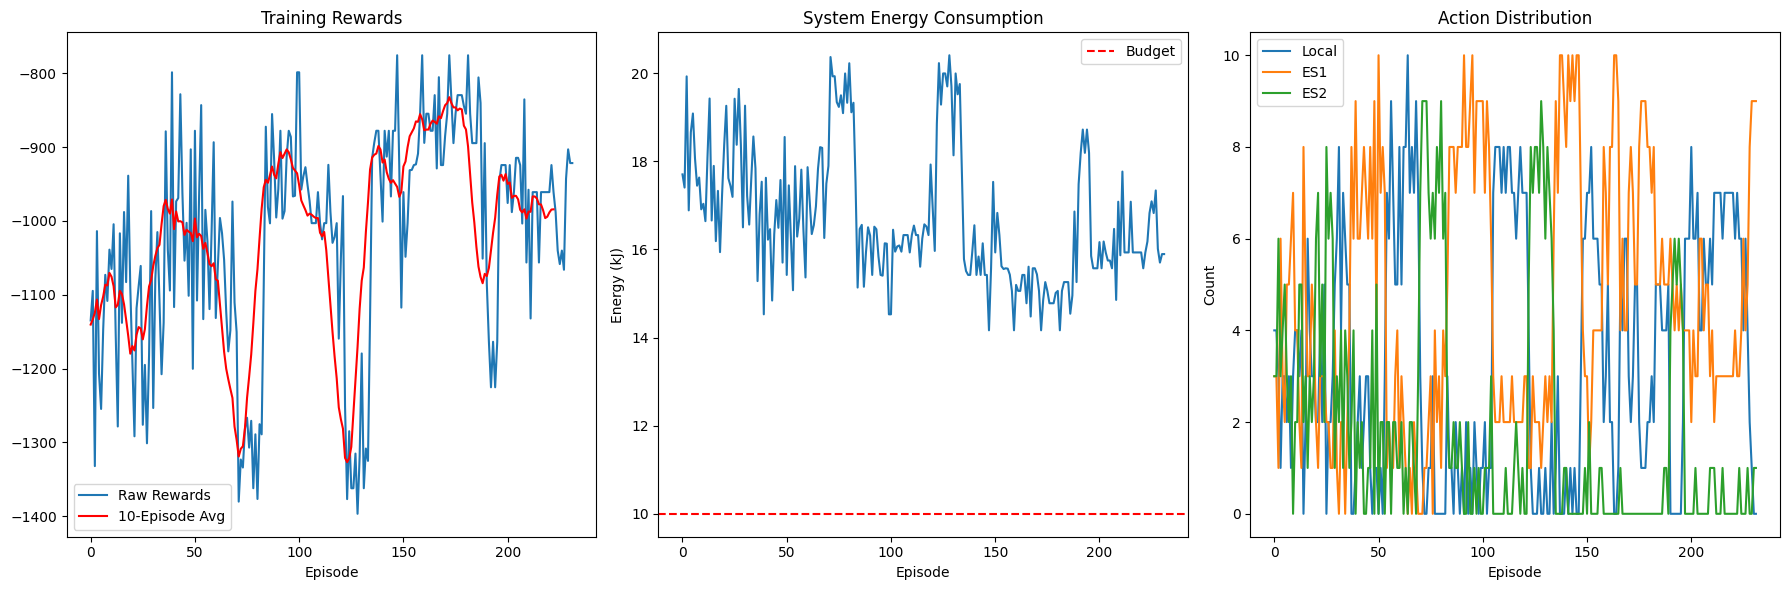

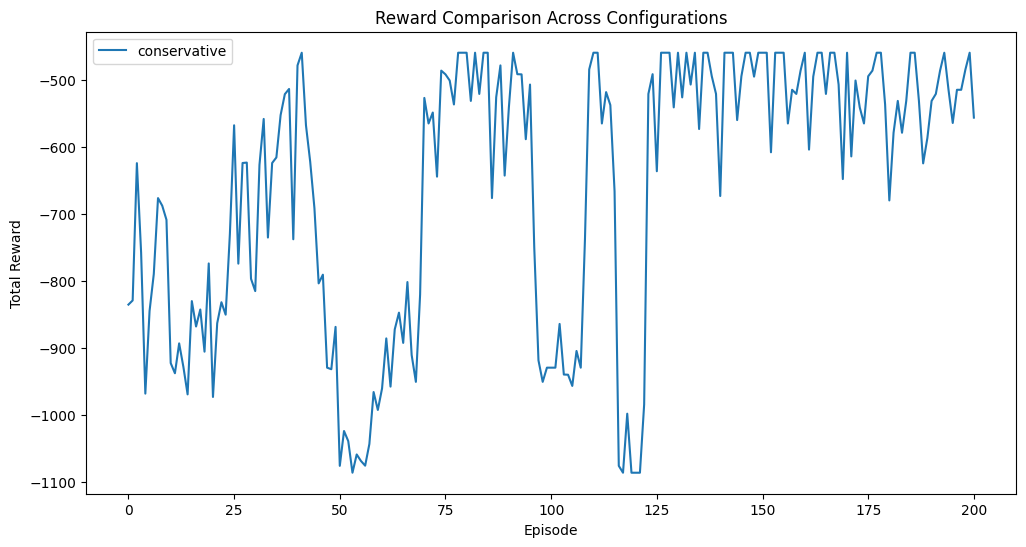

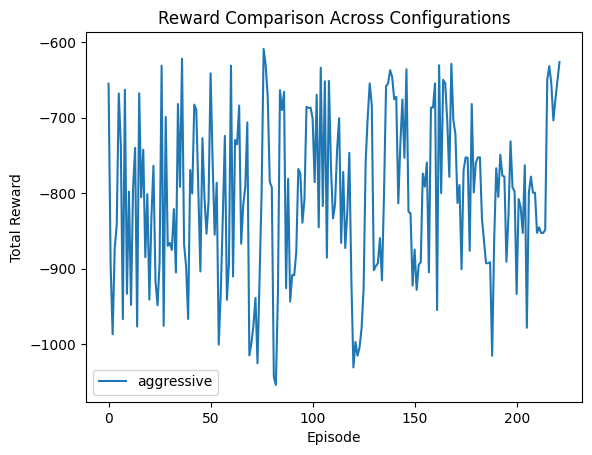

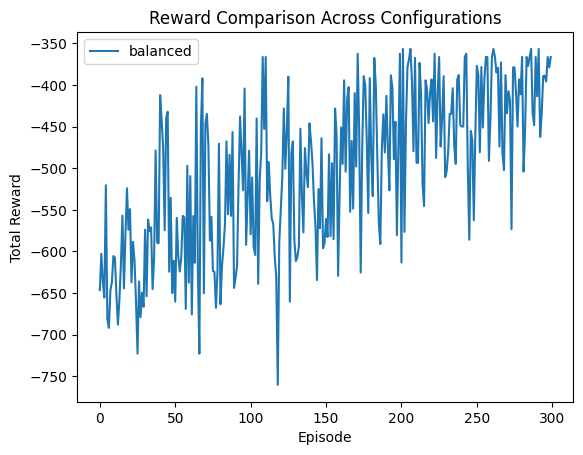

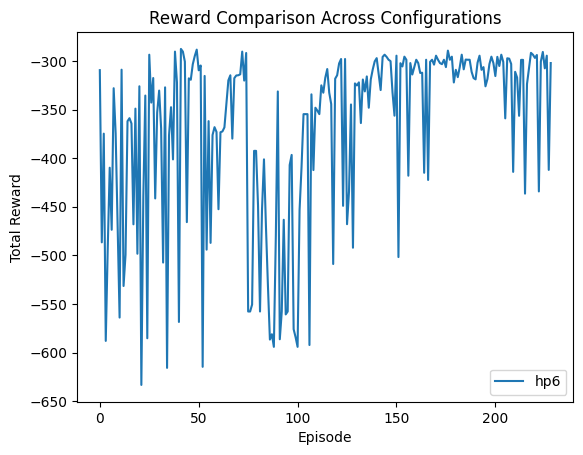

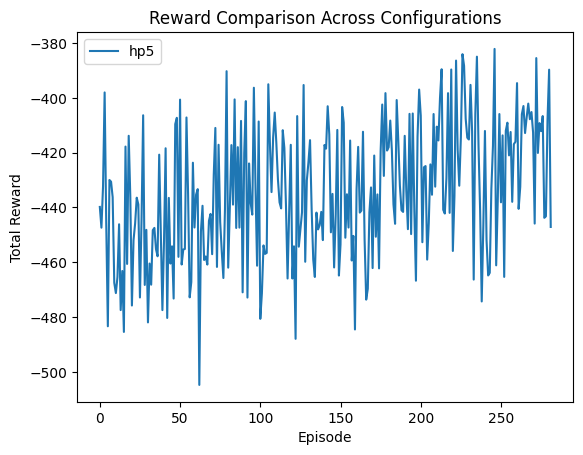

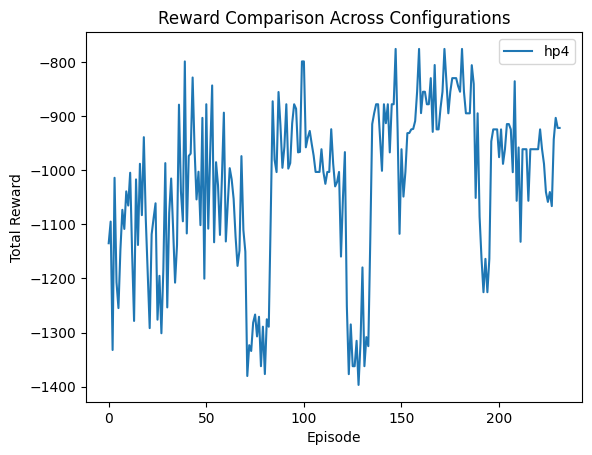

In [ ]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random
import os

# Set global seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

class HyperparameterManager:
    def __init__(self, config):
        self.config = config
        
    def configure_environment(self, env):
        env.task_reward = self.config.get('task_reward', 8.0)
        env.energy_penalty_scale = self.config.get('energy_penalty_scale', 0.0015)
        env.budget_penalty = self.config.get('budget_penalty', 10.0)
        env.efficiency_bonus = self.config.get('efficiency_bonus', 2.0)
        env.energy_budget = self.config.get('energy_budget', 10000)
        return env
        
    def configure_agent(self, agent):
        agent.memory = PrioritizedReplayBuffer(
            self.config.get('memory_size', 100000),
            self.config.get('prioritization_alpha', 0.6)
        )
        agent.batch_size = self.config.get('batch_size', 256)
        agent.gamma = self.config.get('gamma', 0.97)
        agent.epsilon = self.config.get('epsilon_init', 1.0)
        agent.epsilon_min = self.config.get('epsilon_min', 0.05)
        agent.epsilon_decay = self.config.get('epsilon_decay', 0.995)
        agent.learning_rate = self.config.get('learning_rate', 0.0005)
        agent.tau = self.config.get('tau', 0.12)
        agent.beta = self.config.get('prioritization_beta', 0.4)
        agent.network_layers = self.config.get('network_layers', [256, 128])
        agent._build_network()
        return agent

class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts
        self.start_time = None

    def start(self):
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        avg_cpu_usage = psutil.cpu_percent() / 100
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,
            "duration": duration
        }

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0
        self.alpha = alpha

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, episode, total_episodes, beta=0.4):
        self.alpha = 0.4 + 0.3 * (episode/total_episodes)
        priorities = self.priorities[:len(self.buffer)] ** self.alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10,
                 task_reward=8.0, energy_penalty_scale=0.0015,
                 budget_penalty=10.0, efficiency_bonus=2.0):
        self.state_shape = None
        self.total_energy = 0
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        self.VOLTAGE_MD = 3.7
        self.VOLTAGE_ES = 12.0
        self.MAH_TO_J = 3.6
        self.operations_per_mb = 1e9
        
        # Configurable parameters
        self.task_reward = task_reward
        self.energy_penalty_scale = energy_penalty_scale
        self.budget_penalty = budget_penalty
        self.efficiency_bonus = efficiency_bonus
        self.energy_budget = 10000  # kJ
        
        # System parameters
        self.md_compute = np.random.uniform(1.5, 3.5, num_md)
        self.es_compute = np.random.uniform(25.0, 35.0, num_es)
        self.task_requirements = np.random.randint(150, 600, num_tasks)
        self.task_to_md = np.random.randint(0, num_md, num_tasks)
        self.md_energy_local = np.random.uniform(4.0, 10.0, num_md)
        self.md_energy_tx = np.random.uniform(0.6, 1.2, num_md)
        self.es_energy_process = np.random.uniform(35.0, 65.0, num_es)
        
        self.md_battery_history = deque(maxlen=3)
        self.es_battery_history = deque(maxlen=3)
        self.reset()

    def reset(self):
        self.initial_md_battery = np.random.randint(3500, 5501, self.num_md)
        self.initial_es_battery = np.random.randint(12000, 25001, self.num_es)
        
        self.md_battery = self.initial_md_battery * self.MAH_TO_J * self.VOLTAGE_MD
        self.es_battery = self.initial_es_battery * self.MAH_TO_J * self.VOLTAGE_ES
        
        self.energy_used = 0
        self.total_energy = 0
        self.current_task = 0
        self.completed_tasks = 0
        self.violations = 0
        self.local_task_count = 0
        self.edge_task_count = 0
        
        self.md_battery_history.clear()
        self.es_battery_history.clear()
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())
        
        return self._get_state()

    def _get_state(self):
        if self.current_task >= self.num_tasks:
            if self.state_shape:
                return np.zeros(self.state_shape)
            state_size = 7 + self.num_es * 5 + 2
            return np.zeros(state_size)

        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        
        max_md_energy = 5000 * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = 20000 * self.MAH_TO_J * self.VOLTAGE_ES
        md_trend = np.mean([batts[md_idx] for batts in self.md_battery_history]) if self.md_battery_history else 0
        es_trend = np.mean([batts.mean() for batts in self.es_battery_history]) if self.es_battery_history else 0
        
        state = [
            self.md_battery[md_idx] / max_md_energy,
            (self.md_battery[md_idx] - self.initial_md_battery[md_idx]) / max_md_energy,
            self.md_compute[md_idx] / 3.5,
            task_size / 600,
            self.md_energy_local[md_idx] / 10.0,
            self.md_energy_tx[md_idx] / 1.2,
            md_trend / max_md_energy,
        ]

        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / max_es_energy,
                (self.es_battery[es_idx] - self.initial_es_battery[es_idx]) / max_es_energy,
                self.es_compute[es_idx] / 35.0,
                self.es_energy_process[es_idx] / 65.0,
                es_trend / max_es_energy
            ])

        state.extend([
            self.current_task / self.num_tasks,
            self.energy_used / self.energy_budget
        ])
        
        if not self.state_shape:
            self.state_shape = np.array(state).shape
            
        return np.array(state, dtype=np.float32)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return self._get_state(), 0, True, {}
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        energy_used = 0
        reward = 0
        file_info = {"file_size_MB": task_size}
        
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())

        try:
            if action == 0:  # Local processing
                self.local_task_count += 1
                energy_needed = self.md_energy_local[md_idx] * (task_size * 1e9) / (self.md_compute[md_idx] * 1e9)
                
                if self.md_battery[md_idx] >= energy_needed:
                    self.md_battery[md_idx] -= energy_needed
                    energy_used = energy_needed
                    self.completed_tasks += 1
                    file_info["processed_at"] = f"MD{md_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError("Insufficient MD energy")

            else:  # Offload processing
                self.edge_task_count += 1
                es_idx = min(action - 1, self.num_es - 1)
                tx_energy = self.md_energy_tx[md_idx] * task_size * 2.5
                process_energy = (self.es_energy_process[es_idx] * 
                                 (task_size * 1e9) / (self.es_compute[es_idx] * 1e9))
                
                if self.md_battery[md_idx] >= tx_energy and self.es_battery[es_idx] >= process_energy:
                    self.md_battery[md_idx] -= tx_energy
                    self.es_battery[es_idx] -= process_energy
                    energy_used = tx_energy + process_energy
                    self.completed_tasks += 1
                    file_info["processed_at"] = f"ES{es_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError("Insufficient offload energy")

            energy_penalty = (energy_used ** 1.5) * self.energy_penalty_scale
            reward = self.task_reward - energy_penalty
            
            if energy_used < 500:
                reward += self.efficiency_bonus

        except RuntimeError:
            reward = -self.task_reward

        self.total_energy += energy_used
        if self.total_energy > self.energy_budget:
            reward -= self.budget_penalty

        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())

        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()
        
        file_info["energy_used_J"] = energy_used
        return next_state, reward, done, {"file_info": file_info}

class DQNAgent:
    def __init__(self, state_size, action_size, total_episodes=100, **kwargs):
        self.state_size = state_size
        self.action_size = action_size
        self.total_episodes = total_episodes
        
        # Default parameters
        self.memory = PrioritizedReplayBuffer(100000)
        self.batch_size = 256
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005
        self.tau = 0.12
        self.beta = 0.4
        self.network_layers = [256, 128]
        
        # Override with kwargs
        self.__dict__.update(kwargs)
        
        self.normalizer = tf.keras.layers.Normalization(axis=-1)
        self.model = self._build_network()
        self.target_model = self._build_network()
        self.update_target_network()

    def _build_network(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = self.normalizer(inputs)
        
        for units in self.network_layers:
            x = tf.keras.layers.Dense(units, activation='swish')(x)
            x = tf.keras.layers.LayerNormalization()(x)
            x = tf.keras.layers.Dropout(0.2)(x)
        
        # Dueling architecture
        value = tf.keras.layers.Dense(1)(x)
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        mean_advantage = tf.keras.layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        outputs = tf.keras.layers.Add()([value, tf.keras.layers.Subtract()([advantage, mean_advantage])])
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=self.learning_rate,
                    decay_steps=10000,
                    decay_rate=0.95
                ),
                clipnorm=1.0
            ),
            loss=tf.keras.losses.Huber()
        )
        return model

    def update_target_network(self):
        self.target_model.set_weights(
            [self.tau * w + (1 - self.tau) * tw 
             for w, tw in zip(self.model.get_weights(), self.target_model.get_weights())]
        )

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        return np.argmax(self.model.predict(state.reshape(1, -1), verbose=0))

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self, episode):
        if len(self.memory.buffer) < self.batch_size:
            return
            
        samples, indices, weights = self.memory.sample(
            self.batch_size, episode, self.total_episodes, self.beta)
        states, actions, rewards, next_states, dones = zip(*samples)
        
        states = np.array(states)
        next_states = np.array(next_states)
        
        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []

        for i in range(len(samples)):
            target = rewards[i] + (1 - dones[i]) * self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target

        self.model.fit(states, current_q, sample_weight=weights, 
                      batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        self.update_target_network()

def train_agent(config, episodes=300):
    tracker = EnergyTracker()
    hp_manager = HyperparameterManager(config)
    
    # Initialize and configure environment
    env = MECEnvironment()
    env = hp_manager.configure_environment(env)
    
    # Initialize and configure agent
    state_size = len(env.reset())
    agent = DQNAgent(state_size, 1 + env.num_es, episodes=episodes)
    agent = hp_manager.configure_agent(agent)

    # Adapt normalizer with initial experiences
    states = []
    print("Adapting normalizer...")
    state = env.reset()
    for _ in range(1000):
        action = np.random.randint(agent.action_size)
        next_state, _, done, _ = env.step(action)
        states.append(state)
        state = next_state if not done else env.reset()
    agent.normalizer.adapt(np.array(states))

    rewards = []
    energy_consumptions = []
    action_distributions = []
    epsilons = []
    betas = []

    best_avg = float('-inf')
    early_stop_counter = 0

    for episode in range(episodes):
        tracker.start()
        state = env.reset()
        
        total_reward = 0
        done = False
        episode_actions = [0] * (env.num_es + 1)

        # Epsilon management
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        epsilons.append(agent.epsilon)

        while not done:
            action = agent.act(state)
            episode_actions[action] += 1
            next_state, reward, done, _ = env.step(action)
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(agent.memory.buffer) > agent.batch_size:
                agent.replay(episode)

        # Capture metrics
        rewards.append(total_reward)
        energy_consumptions.append(env.total_energy / 1000)
        action_distributions.append(episode_actions)
        betas.append(agent.beta)

        # Early stopping check
        if episode >= 150:
            recent_avg = np.mean(rewards[-10:])
            if recent_avg > best_avg:
                best_avg = recent_avg
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= 50:
                print(f"Early stopping at episode {episode+1}")
                break

        print(f"\nEpisode {episode+1}/{episodes}")
        print(f"  Reward: {total_reward:.1f}")
        print(f"  Total Energy: {env.total_energy/1000:.1f}kJ")
        print(f"  Action Distribution: {episode_actions}")

    # Visualization
    plt.figure(figsize=(18, 6))
    
    # Reward progression
    plt.subplot(1, 3, 1)
    plt.plot(rewards, label='Raw Rewards')
    plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), 'r-', label='10-Episode Avg')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.legend()

    # Energy consumption
    plt.subplot(1, 3, 2)
    plt.plot(energy_consumptions)
    plt.title('System Energy Consumption')
    plt.xlabel('Episode')
    plt.ylabel('Energy (kJ)')
    plt.axhline(y=env.energy_budget/1000, color='r', linestyle='--', label='Budget')
    plt.legend()

    # Action distribution
    plt.subplot(1, 3, 3)
    actions_matrix = np.array(action_distributions).T
    labels = ['Local'] + [f'ES{i+1}' for i in range(env.num_es)]
    for i, label in enumerate(labels):
        plt.plot(actions_matrix[i], label=label)
    plt.title('Action Distribution')
    plt.xlabel('Episode')
    plt.ylabel('Count')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'rewards': rewards,
        'energy': energy_consumptions,
        'actions': action_distributions,
        'epsilons': epsilons
    }

# Hyperparameter configurations
HP_CONFIGS = {
    "conservative": {
        'memory_size': 50000,
        'batch_size': 128,
        'gamma': 0.95,
        'epsilon_decay': 0.98,
        'epsilon_min': 0.1,
        'learning_rate': 0.001,
        'tau': 0.1,
        'network_layers': [128, 64],
        'energy_penalty_scale': 0.002,
        'prioritization_beta': 0.5
    },
    "aggressive": {
        'memory_size': 200000,
        'batch_size': 512,
        'gamma': 0.99,
        'epsilon_decay': 0.99,
        'epsilon_min': 0.2,
        'learning_rate': 0.0003,
        'tau': 0.05,
        'network_layers': [512, 256],
        'efficiency_bonus': 3.0,
        'task_reward': 10.0
    },
    "balanced": {
        'memory_size': 100000,
        'batch_size': 256,
        'gamma': 0.97,
        'epsilon_decay': 0.995,
        'epsilon_min': 0.05,
        'learning_rate': 0.0005,
        'tau': 0.12,
        'network_layers': [256, 128],
        'energy_penalty_scale': 0.0015,
        'budget_penalty': 12.0
    },
"hp6": {
    'memory_size': 30000,
    'batch_size': 64,
    'gamma': 0.93,
    'epsilon_decay': 0.97,
    'epsilon_min': 0.2,
    'learning_rate': 0.002,
    'tau': 0.25,
    'network_layers': [64, 32],
    'energy_penalty_scale': 0.001,  # Reduced penalty
    'reward_components': {
        'task': 9.0,
        'efficiency': 1.5,
        'budget': 8.0
    }
},
"hp5": {
    'memory_size': 150000,
    'batch_size': 384,
    'gamma': 0.98,
    'epsilon_decay': 0.998,  # Slower exploration decay
    'epsilon_min': 0.15,
    'learning_rate': 0.0002,
    'tau': 0.08,
    'network_layers': [512, 256, 128],
    'prioritization_alpha': 0.7,  # More aggressive prioritization
    'prioritization_beta': 0.5
},
"hp4": {
    'memory_size': 75000,
    'batch_size': 192,
    'gamma': 0.96,
    'epsilon_decay': 0.985,
    'epsilon_min': 0.05,
    'learning_rate': 0.0007,
    'tau': 0.15,
    'task_reward': 10.0,  # Higher task completion reward
    'efficiency_bonus': 3.0,
    'network_layers': [384, 192]
}
}

def run_experiments(configs, episodes=300):
    results = {}
    for config_name, config in configs.items():
        print(f"\n=== Running {config_name.upper()} configuration ===")
        results[config_name] = train_agent(config, episodes)
    return results

if __name__ == "__main__":
    tf.keras.backend.clear_session()
    final_results = run_experiments(HP_CONFIGS)
    
    # Comparative analysis
    plt.figure(figsize=(12, 6))
    for config_name, results in final_results.items():
        plt.plot(results['rewards'], label=config_name)
        plt.title('Reward Comparison Across Configurations')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.legend()
        plt.show()

New Reward structure


In [30]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random
import os

# Set global seeds for full reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts

    def start(self):
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        avg_cpu_usage = psutil.cpu_percent() / 100  # Convert to fraction
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration  # Joules
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,
            "duration": duration
        }

class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, alpha=0.6, beta=0.4):
        priorities = self.priorities[:len(self.buffer)] ** alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10):
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        self.VOLTAGE_MD = 3.7
        self.VOLTAGE_ES = 12.0
        self.MAH_TO_J = 3.6
        self.operations_per_mb = 1e9
        
        # Reward parameters
        self.task_reward = 8.0
        self.energy_penalty_scale = 0.0015
        self.budget_penalty = 10.0
        self.efficiency_bonus = 2.0
        
        # System parameters
        self.md_compute = np.random.uniform(1.5, 3.5, num_md)
        self.es_compute = np.random.uniform(25.0, 35.0, num_es)
        self.task_requirements = np.random.randint(150, 600, num_tasks)
        self.task_to_md = np.random.randint(0, num_md, num_tasks)
        self.md_energy_local = np.random.uniform(4.0, 10.0, num_md)
        self.md_energy_tx = np.random.uniform(0.6, 1.2, num_md)
        self.es_energy_process = np.random.uniform(35.0, 65.0, num_es)
        
        # Battery history for trend analysis (stores full array snapshots)
        self.md_battery_history = deque(maxlen=3)
        self.es_battery_history = deque(maxlen=3)
        self.state_shape = None
        self.reset()

    def reset(self):
        # Battery initialization
        self.initial_md_battery = np.random.randint(3500, 5501, self.num_md)
        self.initial_es_battery = np.random.randint(12000, 25001, self.num_es)
        
        self.md_battery = self.initial_md_battery * self.MAH_TO_J * self.VOLTAGE_MD
        self.es_battery = self.initial_es_battery * self.MAH_TO_J * self.VOLTAGE_ES
        
        # Energy budget constraints
        self.energy_budget = 10000  # kJ
        self.energy_used = 0
        
        # Task tracking
        self.current_task = 0
        self.completed_tasks = 0
        self.violations = 0
        self.local_task_count = 0
        self.edge_task_count = 0
        
        # Initialize battery history with full array snapshots
        self.md_battery_history.clear()
        self.es_battery_history.clear()
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())
        
        sample_state = self._get_state()
        self.state_shape = sample_state.shape
        return sample_state

    def _get_state(self):
        if self.current_task >= self.num_tasks:
            # Handle terminal state using pre-recorded shape
                if self.state_shape is not None:
                    return np.zeros(self.state_shape)
                # Fallback initialization for first run
                return np.zeros(6 + self.num_es*5 + 2)
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        
        max_md_energy = 5000 * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = 20000 * self.MAH_TO_J * self.VOLTAGE_ES
        
        # Battery trends using full history arrays
        md_trend = np.mean([batts[md_idx] for batts in self.md_battery_history]) \
                   if self.md_battery_history else 0
        es_trend = np.mean([batts.mean() for batts in self.es_battery_history]) \
                   if self.es_battery_history else 0
        
        state = [
            # Mobile device features
            self.md_battery[md_idx] / max_md_energy,
            (self.md_battery[md_idx] - self.initial_md_battery[md_idx]) / max_md_energy,
            self.md_compute[md_idx] / 3.5,
            task_size / 600,
            self.md_energy_local[md_idx] / 10.0,
            self.md_energy_tx[md_idx] / 1.2,
            md_trend / max_md_energy,
        ]

        # Edge server features
        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / max_es_energy,
                (self.es_battery[es_idx] - self.initial_es_battery[es_idx]) / max_es_energy,
                self.es_compute[es_idx] / 35.0,
                self.es_energy_process[es_idx] / 65.0,
                es_trend / max_es_energy
            ])

        # System-wide features
        state.extend([
            self.current_task / self.num_tasks,
            self.energy_used / self.energy_budget
        ])
        
        return np.array(state)

    def step(self, action):
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        energy_used = 0
        reward = 0
        file_info = {"file_size_MB": task_size}

        try:
            if action == 0:  # Local processing
                self.local_task_count += 1
                energy_needed = self.md_energy_local[md_idx] * (task_size * 1e9) / (self.md_compute[md_idx] * 1e9)
                
                if self.md_battery[md_idx] >= energy_needed:
                    self.md_battery[md_idx] -= energy_needed
                    energy_used = energy_needed
                    self.completed_tasks += 1
                    file_info["processed_at"] = f"MD{md_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError("Insufficient MD energy")

            else:  # Offload processing
                self.edge_task_count += 1
                es_idx = min(action - 1, self.num_es - 1)
                tx_energy = self.md_energy_tx[md_idx] * task_size * 2.5
                process_energy = (self.es_energy_process[es_idx] * 
                                 (task_size * 1e9) / (self.es_compute[es_idx] * 1e9))
                
                if self.md_battery[md_idx] >= tx_energy and self.es_battery[es_idx] >= process_energy:
                    self.md_battery[md_idx] -= tx_energy
                    self.es_battery[es_idx] -= process_energy
                    energy_used = tx_energy + process_energy
                    self.completed_tasks += 1
                    file_info["processed_at"] = f"ES{es_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError("Insufficient offload energy")

            # Calculate rewards
            energy_penalty = (energy_used ** 1.5) * self.energy_penalty_scale
            reward = self.task_reward - energy_penalty
            
            if energy_used < 500:
                reward += self.efficiency_bonus

        except RuntimeError:
            reward = -self.task_reward

        # Energy budget constraints
        self.energy_used += energy_used
        if self.energy_used > self.energy_budget:
            reward -= self.budget_penalty

        # Update battery history with full array copies
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())

        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()
        
        file_info["energy_used_J"] = energy_used
        return next_state, reward, done, {"file_info": file_info}

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(50000)
        self.batch_size = 128
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 0.0005
        self.tau = 0.01
        self.model = self._build_dueling_dqn()
        self.target_model = self._build_dueling_dqn()
        self.update_target_network()
        self.beta = 0.4
        self.beta_increment = (1.0 - 0.4) / 100000

    def _build_dueling_dqn(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(256, activation='relu')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        value = tf.keras.layers.Dense(1)(x)
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        mean_advantage = tf.keras.layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        adjusted_advantage = tf.keras.layers.Subtract()([advantage, mean_advantage])
        outputs = tf.keras.layers.Add()([value, adjusted_advantage])
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_network(self):
        model_weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * model_weights[i] + (1 - self.tau) * target_weights[i]
        self.target_model.set_weights(target_weights)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return
        samples, indices, weights = self.memory.sample(self.batch_size, beta=self.beta)
        states, actions, rewards, next_states, dones = zip(*samples)
        states = np.array(states)
        next_states = np.array(next_states)

        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []

        for i in range(self.batch_size):
            target = rewards[i] + (1 - dones[i]) * self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target

        self.model.fit(states, current_q, sample_weight=weights, batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        self.update_target_network()
        self.beta = min(1.0, self.beta + self.beta_increment)

def train_agent(episodes=200):
    tracker = EnergyTracker()
    env = MECEnvironment()
    state_size = len(env.reset())
    agent = DQNAgent(state_size, 1 + env.num_es)

    # Adapt normalizer with initial experiences
    states = []
    print("Adapting normalizer...")
    state = env.reset()
    for _ in range(1000):
        action = np.random.randint(agent.action_size)
        next_state, _, done, _ = env.step(action)
        states.append(state)
        state = next_state if not done else env.reset()
    agent.normalizer.adapt(np.array(states))

    rewards = []
    completion_rates = []
    energy_consumptions = []
    action_distributions = []
    episode_details = []
    epsilons = []
    betas = []

    best_avg = float('-inf')
    early_stop_counter = 0

    for episode in range(episodes):
        tracker.start()
        state = env.reset()
        
        # Capture initial state
        initial_md_battery = env.md_battery.copy()
        initial_es_battery = env.es_battery.copy()
        
        total_reward = 0
        done = False
        episode_actions = [0] * (env.num_es + 1)
        file_details = []

        # Epsilon management
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        epsilons.append(agent.epsilon)

        while not done:
            action = agent.act(state)
            episode_actions[action] += 1
            next_state, reward, done, info = env.step(action)
            
            # Collect file processing details
            file_details.append(info.get("file_info", {}))
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Update network
            if len(agent.memory.buffer) > agent.batch_size:
                agent.replay(episode)

        # Capture final state
        final_md_battery = env.md_battery.copy()
        final_es_battery = env.es_battery.copy()
        energy = tracker.stop()

        # Track metrics
        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks / env.num_tasks)
        energy_consumptions.append(env.total_energy / 1000)  # Convert to kJ
        action_distributions.append(episode_actions)
        betas.append(agent.beta)

        # Store episode details
        episode_info = {
            "episode": episode + 1,
            "initial_md_battery": initial_md_battery,
            "initial_es_battery": initial_es_battery,
            "final_md_battery": final_md_battery,
            "final_es_battery": final_es_battery,
            "file_details": file_details,
            "total_energy_consumed": env.total_energy
        }
        episode_details.append(episode_info)

        # Early stopping check
        if episode >= 30:
            recent_avg = np.mean(rewards[-10:])
            if recent_avg > best_avg:
                best_avg = recent_avg
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= 5:
                print(f"Early stopping at episode {episode+1}")
                break

        # Detailed episode logging
        print(f"\nEpisode {episode+1}/{episodes}")
        print(f"  Reward: {total_reward:.1f}")
        print(f"  Completed Tasks: {env.completed_tasks}/{env.num_tasks}")
        print(f"  Total Energy: {env.total_energy/1000:.1f}kJ (Budget: {env.energy_budget/1000:.1f}kJ)")
        print(f"  Local/Edge Tasks: {env.local_task_count}/{env.edge_task_count}")
        print(f"  Action Distribution: {episode_actions}")
        print(f"  Exploration Parameters: ε={agent.epsilon:.3f}, β={agent.beta:.3f}")
        print(f"  System Energy Usage: {energy['cpu_j']/1000:.1f}kJ")
        print("  Battery Status:")
        print(f"    Initial Mobile: {np.mean(initial_md_battery)/1000:.1f}kJ")
        print(f"    Final Mobile: {np.mean(final_md_battery)/1000:.1f}kJ")
        print(f"    Initial Edge: {np.mean(initial_es_battery)/1000:.1f}kJ")
        print(f"    Final Edge: {np.mean(final_es_battery)/1000:.1f}kJ")
        print("  File Processing Details:")
        for idx, detail in enumerate(file_details):
            print(f"    Task {idx+1}: {detail.get('file_size_MB', 'N/A')}MB "
                  f"processed at {detail.get('processed_at', 'N/A')} "
                  f"using {detail.get('energy_used_J', 0):.1f}J")

    # Performance visualization
    plt.figure(figsize=(18, 6))
    
    # Reward progression
    plt.subplot(1, 3, 1)
    plt.plot(rewards, label='Raw Rewards')
    plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), 'r-', label='10-Episode Avg')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.legend()

    # Energy consumption
    plt.subplot(1, 3, 2)
    plt.plot(energy_consumptions)
    plt.title('System Energy Consumption')
    plt.xlabel('Episode')
    plt.ylabel('Energy (kJ)')
    plt.axhline(y=env.energy_budget/1000, color='r', linestyle='--', label='Budget')
    plt.legend()

    # Action distribution
    plt.subplot(1, 3, 3)
    actions_matrix = np.array(action_distributions).T
    labels = ['Local'] + [f'ES{i+1}' for i in range(env.num_es)]
    for i, label in enumerate(labels):
        plt.plot(actions_matrix[i], label=label)
    plt.title('Action Distribution')
    plt.xlabel('Episode')
    plt.ylabel('Count')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'rewards': rewards,
        'energy': energy_consumptions,
        'completion': completion_rates,
        'actions': action_distributions,
        'details': episode_details
    }

if __name__ == "__main__":
    train_agent()

Adapting normalizer...


AttributeError: 'DQNAgent' object has no attribute 'normalizer'

In [ ]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random
import os

# Set global seeds for full reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts

    def start(self):
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        avg_cpu_usage = psutil.cpu_percent() / 100  # Convert to fraction
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration  # Joules
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,
            "duration": duration
        }

class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, alpha=0.6, beta=0.4):
        priorities = self.priorities[:len(self.buffer)] ** alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=50, load_from_file=None):
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks

        # Fixed physical parameters
        self.VOLTAGE_MD = 3.7
        self.VOLTAGE_ES = 12.0
        self.MAH_TO_J = 3.6
        self.task_reward = 15.0
        self.energy_scale = 5.0
        self.task_penalty = 20.0

        if load_from_file:  # Load full state from file
            self._load_state(load_from_file)
        else:  # Initialize new environment
            # Randomly generated parameters
            self.md_compute = np.random.uniform(1.0, 3.0, num_md)
            self.es_compute = np.random.uniform(3.0, 5.0, num_es)
            self.task_requirements = np.random.randint(1, 501, num_tasks)
            self.task_to_md = np.random.randint(0, num_md, num_tasks)
            
            # Energy parameters (derived from random values)
            self.md_energy_local = (np.random.uniform(1000, 3000, num_md)/1000) * self.VOLTAGE_MD
            self.md_energy_tx = np.random.uniform(0.0001, 0.0003, num_md) * self.MAH_TO_J * self.VOLTAGE_MD
            self.es_energy_process = (np.random.uniform(500, 1500, num_es)/1000) * self.VOLTAGE_ES

        self.reset()

    def _load_state(self, filename):
        """Load all environment parameters from file"""
        data = np.load(filename, allow_pickle=True)
        self.md_compute = data['md_compute']
        self.es_compute = data['es_compute']
        self.task_requirements = data['task_requirements']
        self.task_to_md = data['task_to_md']
        self.md_energy_local = data['md_energy_local']
        self.md_energy_tx = data['md_energy_tx']
        self.es_energy_process = data['es_energy_process']

    def save_state(self, filename):
        """Save all environment parameters to file"""
        np.savez(filename,
                 md_compute=self.md_compute,
                 es_compute=self.es_compute,
                 task_requirements=self.task_requirements,
                 task_to_md=self.task_to_md,
                 md_energy_local=self.md_energy_local,
                 md_energy_tx=self.md_energy_tx,
                 es_energy_process=self.es_energy_process)

    def reset(self):
        """Reset dynamic state (batteries and counters)"""
        # Battery initialization (using fixed seed)
        np.random.seed(42)  # Seed for reproducible battery levels
        self.md_battery = np.random.randint(3000, 5001, self.num_md) * self.MAH_TO_J * self.VOLTAGE_MD
        self.es_battery = np.random.randint(10000, 20001, self.num_es) * self.MAH_TO_J * self.VOLTAGE_ES
        
        # Reset counters
        self.current_task = 0
        self.completed_tasks = 0
        self.total_energy = 0
        self.violations = 0
        self.local_task_count = 0
        self.edge_task_count = 0
        
        return self._get_state()

    def _get_state(self):
        if self.current_task >= self.num_tasks:
            return np.zeros(5 + self.num_es*3 + 1)

        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]

        # Normalized state values with J-based metrics
        max_md_energy = 5000 * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = 20000 * self.MAH_TO_J * self.VOLTAGE_ES

        state = [
            self.md_battery[md_idx] / max_md_energy,
            self.md_compute[md_idx] / 3.0,
            task_size / 500,
            self.md_energy_local[md_idx] / (3.0 * self.VOLTAGE_MD),  # Max 3000mA → 3A * 3.7V = 11.1W
            self.md_energy_tx[md_idx] / (0.0003 * self.MAH_TO_J * self.VOLTAGE_MD)
        ]

        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / max_es_energy,
                self.es_compute[es_idx] / 5.0,
                self.es_energy_process[es_idx] / (1.5 * self.VOLTAGE_ES)  # Max 1500mA → 1.5A * 12V = 18W
            ])

        state.append(self.current_task / self.num_tasks)
        return np.array(state)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return np.zeros_like(self._get_state()), 0, True, {}

        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        done = False
        energy_used = 0
        reward = 0

        # Prepare a dictionary to store details for this file/task.
        file_info = {
            "file_size_MB": task_size,
            "processed_at": None,
            "energy_used_J": 0
        }

        if action == 0:  # Local processing
            self.local_task_count += 1
            processing_time = (task_size * 1e6) / (self.md_compute[md_idx] * 1e8)
            energy_needed = self.md_energy_local[md_idx] * processing_time

            if self.md_battery[md_idx] >= energy_needed:
                self.md_battery[md_idx] -= energy_needed
                self.total_energy += energy_needed
                self.completed_tasks += 1
                energy_used = energy_needed
                reward = self.task_reward - (energy_used * self.energy_scale)
            else:
                self.violations += 1
                reward = -self.task_penalty
            file_info["processed_at"] = f"Mobile device {md_idx}"
        else:  # Offload processing
            self.edge_task_count += 1
            es_idx = action - 1
            if es_idx >= self.num_es:
                es_idx = self.num_es - 1

            tx_energy = self.md_energy_tx[md_idx] * task_size
            processing_time = (task_size * 1e6) / (self.es_compute[es_idx] * 1e9)
            process_energy = self.es_energy_process[es_idx] * processing_time

            if self.md_battery[md_idx] >= tx_energy and self.es_battery[es_idx] >= process_energy:
                self.md_battery[md_idx] -= tx_energy
                self.es_battery[es_idx] -= process_energy
                self.total_energy += tx_energy + process_energy
                self.completed_tasks += 1
                energy_used = tx_energy + process_energy
                reward = self.task_reward - (energy_used * self.energy_scale)
            else:
                self.violations += 1
                reward = -self.task_penalty
            file_info["processed_at"] = f"Edge server {es_idx}"

        file_info["energy_used_J"] = energy_used
        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()

        # Include file_info in the info dict for tracking.
        info = {"file_info": file_info}
        return next_state, reward, done, info

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(50000)
        self.batch_size = 128
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 0.0005
        self.tau = 0.01
        self.model = self._build_dueling_dqn()
        self.target_model = self._build_dueling_dqn()
        self.update_target_network()
        self.beta = 0.4
        self.beta_increment = (1.0 - 0.4) / 100000

    def _build_dueling_dqn(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(256, activation='relu')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        value = tf.keras.layers.Dense(1)(x)
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        mean_advantage = tf.keras.layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        adjusted_advantage = tf.keras.layers.Subtract()([advantage, mean_advantage])
        outputs = tf.keras.layers.Add()([value, adjusted_advantage])
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_network(self):
        model_weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * model_weights[i] + (1 - self.tau) * target_weights[i]
        self.target_model.set_weights(target_weights)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return
        samples, indices, weights = self.memory.sample(self.batch_size, beta=self.beta)
        states, actions, rewards, next_states, dones = zip(*samples)
        states = np.array(states)
        next_states = np.array(next_states)

        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []

        for i in range(self.batch_size):
            target = rewards[i] + (1 - dones[i]) * self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target

        self.model.fit(states, current_q, sample_weight=weights, batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        self.update_target_network()
        self.beta = min(1.0, self.beta + self.beta_increment)

def train_agent(episodes=80):
    tracker = EnergyTracker()
    env = MECEnvironment()
    state_size = len(env._get_state())
    agent = DQNAgent(state_size, 1 + env.num_es)

    rewards = []
    completion_rates = []
    energy_consumptions = []
    action_distribution = []
    episode_details = []  # To store detailed info per episode

    for episode in range(episodes):
        tracker.start()
        # Record initial battery levels (make copies so later changes don't affect these)


        state = env.reset()
        
        initial_md_battery = env.md_battery.copy()
        initial_es_battery = env.es_battery.copy()
        total_reward = 0
        done = False
        episode_actions = [0] * (env.num_es + 1)  # Track action distribution
        file_details = []  # To store details for each file processed

        while not done:
            action = agent.act(state)
            episode_actions[action] += 1

            next_state, reward, done, info = env.step(action)
            # Append the file-level details from this step
            file_details.append(info.get("file_info", {}))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.replay()

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        energy = tracker.stop()

        # Record final battery levels after processing all tasks
        final_md_battery = env.md_battery.copy()
        final_es_battery = env.es_battery.copy()

        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks / env.num_tasks)
        energy_consumptions.append(env.total_energy)
        action_distribution.append(episode_actions)

        # Store episode details
        episode_info = {
            "episode": episode + 1,
            "initial_md_battery": initial_md_battery,
            "initial_es_battery": initial_es_battery,
            "final_md_battery": final_md_battery,
            "final_es_battery": final_es_battery,
            "file_details": file_details,  # list of dicts for each file
            "total_energy_consumed": env.total_energy
        }
        episode_details.append(episode_info)

        # Print summary for the episode including additional details
        print(f"Episode {episode + 1}: Reward: {total_reward:.1f}")
        print(f"  Completed Tasks: {env.completed_tasks}, Total Energy: {env.total_energy:.1f}kJ")
        print(f"  Local Tasks: {env.local_task_count}, Edge Tasks: {env.edge_task_count}")
        print(f"  Action Distribution: {episode_actions}")
        print(f"  CPU Energy: {energy['cpu_j']:.1f}kJ, Epsilon: {agent.epsilon:.3f}")
        print("  Initial Mobile Batteries:", initial_md_battery)
        print("  Initial Edge Batteries:", initial_es_battery)
        print("  Final Mobile Batteries:", final_md_battery)
        print("  Final Edge Batteries:", final_es_battery)
        print("  File Details (per task):")
        for idx, detail in enumerate(file_details):
            print(f"    File {idx + 1}: Size = {detail.get('file_size_MB', 'N/A')} MB, Processed at = {detail.get('processed_at', 'N/A')}, Energy used = {detail.get('energy_used_J', 0):.2f} J")
        print()

    # Optionally, plot overall performance graphs for rewards, completion rates, and energy consumption.
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards)
    plt.title('Training Rewards')

    plt.subplot(1, 3, 2)
    plt.plot(completion_rates)
    plt.title('Completion Rate')

    plt.subplot(1, 3, 3)
    plt.plot(np.array(energy_consumptions) / 1000)
    plt.title('System Energy (kJ)')

    plt.tight_layout()
    plt.show()

    # You can also return episode_details if further analysis is desired.
    return episode_details

if __name__ == "__main__":
    train_agent()